# Lecture 2 Finance Practice
#### yh_df finance (Peru / US)
- **BCRPyh_df API (Peru)** (official): https://estadisticas.bcrp.gob.pe/estadisticas/series/ayuda/api
- **Yahoo Finance** via `yfinance` (US market yh_df): https://ranaroussi.github.io/yfinance/

## BCRP

In [1]:
import numpy as np
import pandas as pd

pd.set_option("display.max_columns", 120)

In [2]:
START = "2022-01-01"
END = "2025-12-18"

In [3]:
# --- BCRP: daily exchange rate PEN/USD buy & sell (official API) ---
# Codes:
# - PD04637PD: USD/PEN (buy)
# - PD04638PD: USD/PEN (sell)

import requests

bcrp_url = f"https://estadisticas.bcrp.gob.pe/estadisticas/series/api/PD04637PD-PD04638PD/json/{START}/{END}/esp"
try:
    r = requests.get(bcrp_url, timeout=30)
    r.raise_for_status()
    bcrp_obj = r.json()
except Exception as e:
    bcrp_obj = {"periods": []}
    print("BCRP request failed:", type(e).__name__, str(e))

periods = bcrp_obj.get("periods", [])
rows = []
for p in periods:
    name = p.get("name")
    vals = p.get("values", [])
    if isinstance(vals, str):
        vals = [vals]
    if name is None or not isinstance(vals, list) or len(vals) < 2:
        continue
    rows.append([name, vals[0], vals[1]])

df = pd.DataFrame(rows, columns=["date_raw", "PENUSD_buy", "PENUSD_sell"])
df

BCRP request failed: HTTPError 403 Client Error: Forbidden for url: https://estadisticas.bcrp.gob.pe/estadisticas/series/api/PD04637PD-PD04638PD/json/2022-01-01/2025-12-18/esp


Empty DataFrame
Columns: [date_raw, PENUSD_buy, PENUSD_sell]
Index: []

In [4]:
month_map = {
    "Ene": "Jan", "Feb": "Feb", "Mar": "Mar", "Abr": "Apr",
    "May": "May", "Jun": "Jun", "Jul": "Jul", "Ago": "Aug",
    "Set": "Sep", "Oct": "Oct", "Nov": "Nov", "Dic": "Dec"
}

df["date"] = pd.to_datetime(
    df["date_raw"]
      .replace(month_map, regex=True)
      .pipe(pd.to_datetime, format="%d.%b.%y")
)
df

Empty DataFrame
Columns: [date_raw, PENUSD_buy, PENUSD_sell, date]
Index: []

In [5]:

# Convert numeric
if df.shape[0] > 0:
    df["PENUSD_buy"] = pd.to_numeric(df["PENUSD_buy"].replace({"n.d.": np.nan, "nd": np.nan, "N.D.": np.nan}), errors="coerce")
    df["PENUSD_sell"] = pd.to_numeric(df["PENUSD_sell"].replace({"n.d.": np.nan, "nd": np.nan, "N.D.": np.nan}), errors="coerce")

In [6]:
df

Empty DataFrame
Columns: [date_raw, PENUSD_buy, PENUSD_sell, date]
Index: []

### YAHOO Function

In [7]:
# --- Yahoo Finance via yfinance: US tickers (real market yh_df) ---
tickers = ["SPY", "QQQ", "TLT", "GLD", "EEM"]
# SPY : S&P 500 index
# QQQ : Nasdaq-100 index
# TLT : U.S. Treasury bonds with 20+ year maturity
# GLD : Physical gold prices
# EEM : MSCI Emerging Markets index

try:
    import yfinance as yf
except Exception as e:
    yf = None
    print("Could not import yfinance:", type(e).__name__, str(e))

if yf is not None:
    try:
        yh_df = yf.download(tickers, start=START, end=END, auto_adjust=True, progress=False)
    except Exception as e:
        yh_df = pd.DataFrame()
        print("yfinance download failed:", type(e).__name__, str(e))
else:
    yh_df = pd.DataFrame()

# Convert to long format: date, ticker, close, volume
if isinstance(yh_df, pd.DataFrame) and yh_df.shape[0] > 0:
    if isinstance(yh_df.columns, pd.MultiIndex):
        close = yh_df["Close"].copy()
        vol = yh_df["Volume"].copy()
    else:
        close = yh_df[["Close"]].rename(columns={"Close": tickers[0]})
        vol = yh_df[["Volume"]].rename(columns={"Volume": tickers[0]})

    close.index.name = "date"
    vol.index.name = "date"

    us_close_long = close.reset_index().melt(id_vars="date", var_name="ticker", value_name="close")
    us_vol_long = vol.reset_index().melt(id_vars="date", var_name="ticker", value_name="volume")
    us_mkt = us_close_long.merge(us_vol_long, on=["date","ticker"], how="inner").dropna(subset=["close"])
else:
    us_mkt = pd.DataFrame(columns=["date","ticker","close","volume"])

us_mkt.head(), us_mkt.shape

(        date ticker      close    volume
 0 2022-01-03    EEM  44.624966  27572700
 1 2022-01-04    EEM  44.470772  24579500
 2 2022-01-05    EEM  43.745163  46425100
 3 2022-01-06    EEM  43.944706  34288700
 4 2022-01-07    EEM  44.343788  32640900,
 (4970, 4))

In [8]:
# INEI: read correctly using '|' as delimiter (pipe-separated file)
inei_url = "https://www.datosabiertos.gob.pe/sites/default/files/Cap.%20100_Vivienda-Hogar_Muestra.csv"

inei = pd.read_csv(
    inei_url,
    sep="|",            # <-- key fix: the file is pipe-separated
    nrows=3000,
    low_memory=False,
    encoding_errors="replace"
)

inei.shape, list(inei.columns)[:5], inei.head()


((200, 286),
 ['ANIO', 'MES', 'CONGLOME', 'VIVIENDA', 'HOGAR'],
    ANIO  MES  CONGLOME  VIVIENDA  HOGAR  UBIGEO  DOMINIO  ESTRATO  PERIODO  \
 0  2008    6         1        15     11   10101        4        4        3   
 1  2008    6         1        46     11   10101        4        4        3   
 2  2008    6         1        62     11   10101        4        4        3   
 3  2008    6         1        88     11   10101        4        4        3   
 4  2008    6         1        99     11   10101        4        4        3   
 
    TIPO  RFINAL  REEMPLAZO  P101  P102  P102_A  P103  P104_1  P104_A1  \
 0     1       4          0   NaN   NaN     NaN   NaN     NaN      NaN   
 1     1       1          0   1.0   2.0     NaN  40.0     2.0      NaN   
 2     1       1          0   1.0   2.0     NaN  50.0     2.0      NaN   
 3     1       1          0   1.0   2.0     NaN  30.0     2.0      NaN   
 4     1       1          0   1.0   2.0     NaN  20.0     2.0      NaN   
 
    P104_B1  P

## 3.2 Pandas Series

### 3.2.1 From lists to Series exercise

Using `df`:

1. Create `PENUSD_mid = (PENUSD_buy + PENUSD_sell) / 2`.
2. Take the **last 15 mid values** as a Python list.
3. Create a `pd.Series` from that list.
4. Name it `PENUSD_mid_last15`.

In [9]:
df["PENUSD_mid"] = (df["PENUSD_buy"] + df["PENUSD_sell"]) / 2

PENUSD_mid_last15 = pd.Series(
    df["PENUSD_mid"].dropna().tail(15).tolist(),
    name="PENUSD_mid_last15"
)

PENUSD_mid_last15

Series([], Name: PENUSD_mid_last15, dtype: object)

### 3.2.2 From NumPy array to Series 

Using `us_mkt`:

1. Filter to `ticker == "SPY"`.
2. Take `close` as a NumPy array.
3. Create a Series indexed by `date` named `SPY_close_series`.
4. Compute the mean/min/max with Series methods.

In [10]:

# 1 Filter rows where ticker == "SPY" and keep only the columns we need.
spy_df = us_mkt.loc[us_mkt["ticker"].eq("SPY"), ["date", "close"]].dropna(subset=["date", "close"])

# 2 Convert the 'close' column to a NumPy array (this is what the exercise asks for)
spy_close_np = spy_df["close"].to_numpy()

# 3 Convert the 'date' column to datetime and use it as the Series index.
#    Name the Series exactly as required: "SPY_close_series".
SPY_close_series = pd.Series(
    spy_close_np,
    index=pd.to_datetime(spy_df["date"]),
    name="SPY_close_series"
)

# 4 Compute summary statistics using pandas Series methods.
summary_stats = {
    "mean": SPY_close_series.mean(),
    "min": SPY_close_series.min(),
    "max": SPY_close_series.max(),
}

SPY_close_series.head(), summary_stats

(date
 2022-01-03    451.875153
 2022-01-04    451.723785
 2022-01-05    443.049713
 2022-01-06    442.633545
 2022-01-07    440.883636
 Name: SPY_close_series, dtype: float64,
 {'mean': np.float64(485.6085835078832),
  'min': 341.1820373535156,
  'max': 687.1395263671875})

### 3.2.3 From Dictionary to Series 

Using `us_mkt`:

1. Compute the **last available close** for each ticker in `tickers`.
2. Store it in a dict `{ticker: last_close}`.
3. Convert to a Series and sort descending.

In [11]:
# Ensure we have only the relevant columns, remove missing closes, and sort by date
tmp = us_mkt.loc[:, ["date", "ticker", "close"]].dropna(subset=["date", "close"]).copy()
tmp["date"] = pd.to_datetime(tmp["date"])
tmp = tmp.sort_values(["ticker", "date"])

# Step 1 + 2: build dict {ticker: last_close}
last_close_by_ticker = (
    tmp.groupby("ticker")["close"]
       .last()                 # last row per ticker after sorting by date
       .to_dict()              # convert to dict
)

# Step 3: convert dict -> Series and sort descending
last_close_series = (
    pd.Series(last_close_by_ticker, dtype=float)
      .sort_values(ascending=False)
)

last_close_series

SPY    669.421936
QQQ    599.637390
GLD    399.290009
TLT     87.459633
EEM     52.599998
dtype: float64

### 3.2.4 Series vs NumPy 

Goal: show why pandas alignment matters.

1. Create two Series indexed by date:
   - df mid-rate from `df`
   - SPY close from `us_mkt`
2. Combine them into a yh_dfFrame (pandas aligns on dates).
3. Separately, build two NumPy arrays by truncating to the same length.
4. In markdown: explain why alignment is safer.

In [12]:
# --- df mid-rate Series (indexed by date) ---
df_mid = (
    df.loc[:, ["date", "PENUSD_buy", "PENUSD_sell"]]
      .dropna(subset=["date", "PENUSD_buy", "PENUSD_sell"])
      .assign(PENUSD_mid=lambda d: (d["PENUSD_buy"] + d["PENUSD_sell"]) / 2)
      .set_index("date")["PENUSD_mid"]
      .sort_index()
)

# --- SPY close Series (indexed by date) ---
spy_close = (
    us_mkt.loc[us_mkt["ticker"].eq("SPY"), ["date", "close"]]
         .dropna(subset=["date", "close"])
)

spy_close["date"] = pd.to_datetime(spy_close["date"])
spy_close_series = spy_close.set_index("date")["close"].sort_index()

# --- pandas alignment: align on the date index automatically ---
aligned_df = pd.DataFrame({"df_mid": df_mid, "SPY_close": spy_close_series}).dropna()

# --- NumPy approach: truncate arrays to the same length (no date alignment) ---
# NOTE: This can compare different dates if the series have missing days or different calendars.
n = min(len(df_mid), len(spy_close_series))
df_np = df_mid.to_numpy()[:n]
spy_np = spy_close_series.to_numpy()[:n]

aligned_df.head(), df_np.shape, spy_np.shape

(Empty DataFrame
 Columns: [df_mid, SPY_close]
 Index: [],
 (0,),
 (0,))

### 3.2.5 Indexing 

1. From `last_close_series`, use `.iloc` to select the top 3 tickers.
2. Use `.loc` to select the SPY value.

In [13]:
# 1) Top 3 by position (first three entries)
top3 = last_close_series.iloc[:3]

# 2) SPY value by label (safe lookup: returns NaN if SPY is missing)
spy_value = last_close_series.get("SPY", np.nan)

top3, spy_value

(SPY    669.421936
 QQQ    599.637390
 GLD    399.290009
 dtype: float64,
 np.float64(669.4219360351562))

## 3.3 yh_dfFrame

### 3.3.1 yh_dfFrame Generation 

1. Build a yh_dfFrame with daily df mid-rate and SPY close aligned by date.
2. Create columns:
   - `df_ret` and `SPY_ret` using `pct_change()`
   - `df_abs_change` = absolute day-to-day change in df mid
3. Keep columns in this order:
   `["PENUSD_mid","SPY_close","df_ret","SPY_ret","df_abs_change"]`

In [14]:
# --- Step 1: Create the df mid-rate series indexed by date ---
# We compute the mid-rate as the average of buy and sell, then keep it as a clean, date-indexed Series.
df_mid = (
    df.loc[:, ["date", "PENUSD_buy", "PENUSD_sell"]]
      .dropna(subset=["date", "PENUSD_buy", "PENUSD_sell"])                 # remove rows with missing pieces
      .assign(PENUSD_mid=lambda d: (d["PENUSD_buy"] + d["PENUSD_sell"]) / 2) # mid = (buy + sell)/2
      .set_index("date")["PENUSD_mid"]                                      # turn into a Series indexed by date
      .sort_index()                                                         # sort so time-based operations make sense
)

# --- Step 2: Create the SPY close series indexed by date ---
# We filter us_mkt to SPY only, then build a clean Series with date as the index.
spy_close_series = (
    us_mkt.loc[us_mkt["ticker"].eq("SPY"), ["date", "close"]]   # keep only SPY rows and the needed columns
         .dropna(subset=["date", "close"])                      # drop missing dates/closes
)
spy_close_series["date"] = pd.to_datetime(spy_close_series["date"])          # ensure dates are true datetimes
spy_close_series = (
    spy_close_series.set_index("date")["close"]                # make it a Series indexed by date
                  .sort_index()                                # sort by date
)

# --- Step 3: Align df and SPY by date in a single yh_dfFrame ---
# Pandas aligns automatically by the index (date). dropna() keeps only dates present in BOTH series.
df = pd.DataFrame({
    "PENUSD_mid": df_mid,
    "SPY_close": spy_close_series
}).dropna()

# --- Step 4: Create return and change features ---
# pct_change() computes (today / yesterday - 1), i.e., simple daily returns.
df_features = df.copy()
df_features["df_ret"] = df_features["PENUSD_mid"].pct_change()               # daily df return
df_features["SPY_ret"] = df_features["SPY_close"].pct_change()               # daily SPY return

# Absolute day-to-day change in df mid-rate (in PEN per USD).
df_features["df_abs_change"] = df_features["PENUSD_mid"].diff().abs()        # |mid_t - mid_{t-1}|

# --- Step 5: Keep columns in the required order ---
df_features = df_features[["PENUSD_mid", "SPY_close", "df_ret", "SPY_ret", "df_abs_change"]]

df_features.head()

Empty DataFrame
Columns: [PENUSD_mid, SPY_close, df_ret, SPY_ret, df_abs_change]
Index: []

### 3.3.2 Indexing 

1. Use `.iloc` to select first 10 rows of returns only.
2. Use `.loc` to select a date range in 2024.

In [15]:
# 1) First 10 rows of returns only (position-based)
first10_rets = df_features.loc[:, ["df_ret", "SPY_ret"]].iloc[:10]

# 2) Date range selection in 2024 (label-based, using the datetime index)
range_2024 = df_features.loc["2024-01-01":"2024-12-31"]

first10_rets, range_2024.head()

(Empty DataFrame
 Columns: [df_ret, SPY_ret]
 Index: [],
 Empty DataFrame
 Columns: [PENUSD_mid, SPY_close, df_ret, SPY_ret, df_abs_change]
 Index: [])

### 3.3.3 General Methods 
1. Use `.describe()` for return columns.
2. Find the 5 highest SPY daily returns and the dates.
3. Create `df_direction` = "up" if `df_ret > 0` else "down".
4. Count how many "up" days per calendar year.

In [16]:
# Make sure df_direction exists (from the previous step)
df_features["df_direction"] = np.where(df_features["df_ret"] > 0, "up", "down")

# Extract years only for "up" days (this returns an array of years, one per "up" day)
up_years = df_features.index[df_features["df_direction"].eq("up")].year

# Count occurrences of each year (no groupby used)
up_days_per_year = pd.Series(up_years).value_counts().sort_index()

up_days_per_year

Series([], Name: count, dtype: int64)

### 3.3.4 Importing yh_df 

Using INEI sample `inei`:

1. Display shape and first 5 columns.
2. Pick 2 columns and rename to snake_case.
3. Keep only those 2 columns in a new yh_dfFrame `inei_small`.

In [17]:
# 3.3.4 Importing yh_df (solution after reading with sep="|")
#
# 1) Show shape and first 5 columns
inei_shape = inei.shape
inei_first5_cols = list(inei.columns)[:5]

# 2) Pick two columns and rename to snake_case
inei_small = (
    inei.loc[:, ["ANIO", "MES"]]
        .rename(columns={"ANIO": "year", "MES": "month"})
)

inei_shape, inei_first5_cols, inei_small.head()


((200, 286),
 ['ANIO', 'MES', 'CONGLOME', 'VIVIENDA', 'HOGAR'],
    year  month
 0  2008      6
 1  2008      6
 2  2008      6
 3  2008      6
 4  2008      6)

### 3.3.5 Filtering yh_df 

Using `df_features`:

1. Filter days where `SPY_ret < -0.02` (large negative days).
2. Filter days where `df_abs_change` is in the top 1%.
3. Compare counts.

In [18]:
# 1) Days where SPY had a large negative return (< -2%)
neg_spy_days = df_features.loc[df_features["SPY_ret"] < -0.02]

# 2) Days where df_abs_change is in the top 1% (>= 99th percentile)
df_threshold = df_features["df_abs_change"].quantile(0.99)
df_jump_days = df_features.loc[df_features["df_abs_change"] >= df_threshold]

len(neg_spy_days), len(df_jump_days)

(0, 0)

### 3.3.6 Dealing with Nulls 
Using `us_mkt`:

1. Copy `us_mkt` to `us_mkt_nan`.
2. Set 1% of `close` to NaN (fixed random seed).
3. Create:
   - `us_drop`: drop NaNs
   - `us_fill`: fill NaNs with ticker-specific median close
4. Compare shapes.

In [19]:
# 1 Copy
us_mkt_nan = us_mkt.copy()

# 2 Set ~1% of close to NaN 
idx = us_mkt_nan.sample(frac=0.01, random_state=42).index
us_mkt_nan.loc[idx, "close"] = np.nan

# 3 Drop NaNs
us_drop = us_mkt_nan.dropna(subset=["close"]).copy()

# Fill NaNs with ticker-specific median (NO groupby)
tickers_unique = us_mkt_nan["ticker"].dropna().unique()

median_by_ticker = {
    t: us_mkt_nan.loc[us_mkt_nan["ticker"].eq(t), "close"].median()
    for t in tickers_unique
}

us_fill = us_mkt_nan.copy()
us_fill["close"] = us_fill["close"].fillna(us_fill["ticker"].map(median_by_ticker))

# 4 Compare shapes
us_mkt.shape, us_mkt_nan.shape, us_drop.shape, us_fill.shape

((4970, 4), (4970, 4), (4920, 4), (4970, 4))

### 3.3.7 Duplicates 

1. Create `dup_df` by stacking the last 5 rows of `us_mkt` twice.
2. Detect duplicates using `.duplicated()`.
3. Remove them using `.drop_duplicates()`.

In [20]:
# 1Stack the last 5 rows twice
last5 = us_mkt.tail(5)
dup_df = pd.concat([last5, last5], axis=0, ignore_index=True)

# 2 Detect duplicates (True means "this row is a duplicate of a previous row")
dup_mask = dup_df.duplicated()

# 3 Remove duplicates (keep the first occurrence by default)
dedup_df = dup_df.drop_duplicates().reset_index(drop=True)

dup_df.shape, dedup_df.shape


((10, 4), (5, 4))

### 3.3.8 Groupby 


Using `us_mkt`:

1. Group by `ticker` and compute:
   - mean close
   - median close
   - max volume
2. Rename columns clearly.
3. Sort by mean close descending.

In [21]:
ticker_summary = (
    us_mkt
    .dropna(subset=["ticker", "close"])              # ensure close exists for the stats
    .groupby("ticker")
    .agg(
        mean_close=("close", "mean"),                # average close per ticker
        median_close=("close", "median"),            # median close per ticker
        max_volume=("volume", "max")                 # max volume per ticker (NaN-safe)
    )
    .sort_values("mean_close", ascending=False)      # highest mean close first
)

ticker_summary

mean_close  median_close  max_volume
ticker                                      
SPY     485.608584    460.740021   256611400
QQQ     411.276967    400.214539   198685800
GLD     220.130422    187.864998    62025000
TLT      91.395622     88.549721   131353500
EEM      40.462350     39.107407   134225700

### 3.3.9 Reshape 

1. Create a 1-row wide yh_dfFrame with last closes per ticker.
2. Convert it to long format with `melt()` into columns: `ticker`, `last_close`.
3. Pivot `us_mkt` into a wide table: index=`date`, columns=`ticker`, values=`close` (keep first 50 dates).

In [22]:
# 1  1-row wide yh_dfFrame with last closes per ticker ---
# We sort by ticker and date so "last" means the most recent observation for each ticker.
tmp = us_mkt.loc[:, ["date", "ticker", "close"]].dropna(subset=["date", "ticker", "close"]).copy()
tmp["date"] = pd.to_datetime(tmp["date"])
tmp = tmp.sort_values(["ticker", "date"])

# Get last close per ticker (Series indexed by ticker), then convert to a 1-row yh_dfFrame
last_close_series = tmp.groupby("ticker")["close"].last()
wide_last = last_close_series.to_frame().T
wide_last.index = ["last_close"]  # optional: label the single row

# 2 Convert wide -> long using melt() ---
# Reset index so melt has a normal yh_dfFrame to work with.
long_last = (
    wide_last.reset_index(drop=True)
            .melt(var_name="ticker", value_name="last_close")
)

# 3 Pivot long us_mkt into a wide close table (date x ticker) ---
# Pivot creates a table where each ticker is a column and each row is a date.
wide_close = (
    tmp.pivot(index="date", columns="ticker", values="close")
       .sort_index()
       .head(50)
)

wide_last, long_last.head(), wide_close.head()

(ticker            EEM         GLD        QQQ         SPY        TLT
 last_close  52.599998  399.290009  599.63739  669.421936  87.459633,
   ticker  last_close
 0    EEM   52.599998
 1    GLD  399.290009
 2    QQQ  599.637390
 3    SPY  669.421936
 4    TLT   87.459633,
 ticker            EEM         GLD         QQQ         SPY         TLT
 date                                                                 
 2022-01-03  44.624966  168.330002  391.679474  451.875153  125.295372
 2022-01-04  44.470772  169.570007  386.599182  451.723785  124.774384
 2022-01-05  43.745163  169.059998  374.722443  443.049713  124.097130
 2022-01-06  43.944706  166.990005  374.459106  442.633545  124.418381
 2022-01-07  44.343788  167.750000  370.402710  440.883636  123.524002)

### 3.3.10 Merge (Assignment)

Goal: merge Peru macro yh_df (BCRP) with US market yh_df (Yahoo) at monthly frequency.

1. Fetch BCRP monthly policy rate: code `PD12301MD`.
2. Build a monthly SPY average close from `us_mkt`.
3. Merge the two tables.
4. Save to `outputs/lecture2_policy_spy_monthly.csv`.

In [23]:
# Fetch BCRP monthly policy rate (official API)
START = "2025-01-01"
END = "2025-12-18"
headers = {
    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0 Safari/537.36",
    "Accept": "application/json",
}

policy_url = f"https://estadisticas.bcrp.gob.pe/estadisticas/series/api/PD12301MD/json/{START}/{END}/esp"
try:
    r = requests.get(policy_url, timeout=30, headers = headers)
    r.raise_for_status()
    pol_obj = r.json()
except Exception as e:
    pol_obj = {"periods": []}
    print("BCRP policy request failed:", type(e).__name__, str(e))

rows = []
for p in pol_obj.get("periods", []):
    name = p.get("name")
    vals = p.get("values", [])
    if isinstance(vals, str):
        vals = [vals]
    if name is None or not isinstance(vals, list) or len(vals) < 1:
        continue
    rows.append([name, vals[0]])

policy = pd.DataFrame(rows, columns=["date_raw", "policy_rate"])
if policy.shape[0] > 0:
    policy["policy_rate"] = pd.to_numeric(policy["policy_rate"].replace({"n.d.": np.nan, "nd": np.nan, "N.D.": np.nan}), errors="coerce")

    s = policy["date_raw"].astype(str).str.strip()
    dt_iso = pd.to_datetime(s, errors="coerce")

    mask_monthly = s.str.match(r"^[A-Za-zÁÉÍÓÚÑñ]{3}\.[0-9]{4}$", na=False)
    mon_map = {
        "Ene":"Jan","Feb":"Feb","Mar":"Mar","Abr":"Apr","May":"May","Jun":"Jun",
        "Jul":"Jul","Ago":"Aug","Set":"Sep","Sep":"Sep","Oct":"Oct","Nov":"Nov","Dic":"Dec"
    }
    mon_es = s.where(mask_monthly).str.slice(0,3)
    year4 = s.where(mask_monthly).str.slice(4,8)
    mon_en = mon_es.map(mon_map)
    dt_monthly = pd.to_datetime(mon_en + "." + year4, format="%b.%Y", errors="coerce")

    policy["date"] = dt_iso.fillna(dt_monthly)
    policy = policy.dropna(subset=["date"]).sort_values("date").reset_index(drop=True)

policy.head(), policy.tail()

BCRP policy request failed: HTTPError 403 Client Error: Forbidden for url: https://estadisticas.bcrp.gob.pe/estadisticas/series/api/PD12301MD/json/2025-01-01/2025-12-18/esp


(Empty DataFrame
 Columns: [date_raw, policy_rate]
 Index: [],
 Empty DataFrame
 Columns: [date_raw, policy_rate]
 Index: [])

In [24]:
START

'2025-01-01'

In [25]:
from pathlib import Path
Path("outputs").mkdir(exist_ok=True)

spy_monthly = (
    us_mkt.loc[us_mkt["ticker"].eq("SPY"), ["date", "close"]]
         .dropna(subset=["date", "close"])
         .assign(date=lambda d: pd.to_datetime(d["date"]))
         .set_index("date")["close"]
         .resample("M")
         .mean()
         .rename("spy_close_avg")
         .reset_index()
)

policy_monthly = (
    policy.loc[:, ["date", "policy_rate"]]
          .dropna(subset=["date", "policy_rate"])
          .assign(date=lambda d: pd.to_datetime(d["date"]))
          .sort_values("date")
)

merged_monthly = policy_monthly.merge(spy_monthly, on="date", how="inner")

out_path = Path("outputs/lecture_2_finance.csv")
merged_monthly.to_csv(out_path, index=False)

/var/folders/gb/56xms55d53n734tnp7xq55bh0000gq/T/ipykernel_74754/2495546726.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")


KeyError: "['date'] not in index"

# Exercise 1:

### The file ```AMZN_options_2025-12-22.csv``` contains options yh_df for amazon. For those of you not familiar with option yh_df, an option is a financial derivatives that pays at expiration time $T$ and strike $K>0$:

$$C(K,T)=(S_T-K)_+ \text{  if a call option}$$
$$P(K,T)=(K-S_T)_+ \text{  if a put option}$$

It is well known, that Put-Call parity implies the following relation:

$$C(K,T)-P(K,T)=S(T)-K\cdot DF(T)$$
where $S(T)$ is the underlying price and $DF(T)$ is the discount factor.
### a) Compute a new column labelled ```mid_price``` which corresponds to:
$$\text{mid price}=\frac{\text{bid}+\text{ask}}{2}$$
### b) For each available ```expiration_date``` perform a linear regression using the ```mid_price``` only for options ```whose trade_volume>25``` (note that both calls and puts need to satisfy this condition):
$$C(K,T)-P(K,T)=a+b K$$ where $a$ corresponds to $S(T)$ and $b$ corresponds to $DF(T)$.

### you can use ```numpy.polyfit(x, y, deg=1)``` to fit a linear regression and obtain the coefficients
### c) Plot $S(T)$ and  $DF(T)$ as a function of $T$

### Note: you will need to transform dates into time, $T$ in years to to us eyou will need to use the ```datetime``` library. Here goes an example

**Note (2025 yh_df):** In this solution we use the snapshot file `AMZN_options_2025-12-22.csv` (trade_date = 2025-12-22).


In [ ]:
import pandas as pd                      
import datetime                          

# 2025 snapshot from Yahoo (trade_date = 2025-12-22)
option_chain = pd.read_csv('../_data/AMZN_options_2025-12-22.csv')  

# Parse dates
option_chain['expiration_date'] = pd.to_datetime(option_chain['expiration_date'])  
# Convert the 'expiration_date' column from text to real datetime objects,
# so we can subtract dates and do time-to-maturity calculations.

# Use trade_date in the file as valuation date (16:00 close), fallback to hard-coded date
if 'trade_date' in option_chain.columns:  
    # Check if the yh_dfset contains a 'trade_date' column (the snapshot date).
    
    option_chain['trade_date'] = pd.to_datetime(option_chain['trade_date'])  
    # Convert 'trade_date' to datetime as well (same reason: proper date operations).
    
    val_date = option_chain['trade_date'].max()  
    # Take the maximum trade_date in the file. Usually the whole file is one snapshot day,
    # so max() just gives that snapshot date.
    
    current_date = datetime.datetime(val_date.year, val_date.month, val_date.day, 16, 0, 0)  
    # Build a valuation timestamp at 16:00 (market close) on that snapshot day.
    # We use 16:00 because options quotes are often interpreted as end-of-day-ish.
else:
    # If 'trade_date' is not available, we manually set the valuation datetime.
    
    current_date = datetime.datetime(2025, 12, 22, 16, 0, 0)  
    # Hard-code the valuation timestamp to 2025-12-22 at 16:00.

# Normalize option_type to C/P (the original notebook expects 'C' and 'P')
option_chain['option_type'] = (
    option_chain['option_type']                         # Start from the existing option_type column...
    .astype(str)                                        # ...make sure everything is a string...
    .str.lower()                                        # ...lowercase it for consistent matching...
    .map({'call':'C','put':'P','c':'C','p':'P'})         # ...translate call/put labels into 'C'/'P'...
    .fillna(option_chain['option_type'])                 # ...and keep the original value if it wasn’t recognized.
)
# After this, the column should use 'C' for calls and 'P' for puts,
# which matches the notation used in the original exercise.

time_to_maturity_timestamp = option_chain['expiration_date'] - current_date  
# Compute time-to-maturity as a timedelta:
# for each option, this is (expiration_date - valuation_date).
# The result is a pandas Series of timedeltas (e.g., "25 days", "180 days", etc.).


In [ ]:
def timestamp_to_year_fraction(x):
    # This function converts a time difference (a timedelta) into a fraction of a year.
    # We measure the time gap in seconds and then divide by the number of seconds in 365 days.
    # Output example: 0.5 means "half a year" until maturity.

    return (x.days * 24 * 3600 + x.seconds) / (365 * 24 * 3600)
    # x.days gives the whole number of days in the timedelta.
    # x.seconds gives the leftover seconds after removing full days.
    # We convert everything to seconds and divide by (365 days * 24 hours * 3600 seconds).


In [ ]:

option_chain["T"] = time_to_maturity_timestamp.apply(timestamp_to_year_fraction)
# Add T = time to maturity in years (computed from expiration_date - valuation date).

In [ ]:
option_chain.head()

contractSymbol option_type expiration_date  strike     bid     ask  \
0  AMZN251226C00125000           C      2025-12-26   125.0  102.05  105.45   
1  AMZN251226C00130000           C      2025-12-26   130.0   96.95  100.45   
2  AMZN251226C00135000           C      2025-12-26   135.0   91.95   95.45   
3  AMZN251226C00140000           C      2025-12-26   140.0   86.95   90.45   
4  AMZN251226C00145000           C      2025-12-26   145.0   82.10   85.50   

   volume  openInterest  impliedVolatility  inTheMoney trade_date  mid_price  \
0     1.0            17           2.462894        True 2025-12-22     103.75   
1     1.0             8           2.261723        True 2025-12-22      98.70   
2     2.0            31           2.125005        True 2025-12-22      93.70   
3     2.0             3           1.994141        True 2025-12-22      88.70   
4     NaN             2           1.958985        True 2025-12-22      83.80   

          T         S_T      DF_T  
0  0.009132  229.299783  1.003112  
1  0.009132  229.299783  1.003112  
2  0.009132  229.299783  1.003112  
3  0.009132  229.299783  1.003112  
4  0.009132  229.299783  1.003112

# a)

In [ ]:
option_chain["mid_price"] = 0.5 * (option_chain["bid"] + option_chain["ask"])
# Mid price = average of bid and ask quotes.


In [ ]:
option_chain.head()

contractSymbol option_type expiration_date  strike     bid     ask  \
0  AMZN251226C00125000           C      2025-12-26   125.0  102.05  105.45   
1  AMZN251226C00130000           C      2025-12-26   130.0   96.95  100.45   
2  AMZN251226C00135000           C      2025-12-26   135.0   91.95   95.45   
3  AMZN251226C00140000           C      2025-12-26   140.0   86.95   90.45   
4  AMZN251226C00145000           C      2025-12-26   145.0   82.10   85.50   

   volume  openInterest  impliedVolatility  inTheMoney trade_date  mid_price  \
0     1.0            17           2.462894        True 2025-12-22     103.75   
1     1.0             8           2.261723        True 2025-12-22      98.70   
2     2.0            31           2.125005        True 2025-12-22      93.70   
3     2.0             3           1.994141        True 2025-12-22      88.70   
4     NaN             2           1.958985        True 2025-12-22      83.80   

          T         S_T      DF_T  
0  0.009132  229.299783  1.003112  
1  0.009132  229.299783  1.003112  
2  0.009132  229.299783  1.003112  
3  0.009132  229.299783  1.003112  
4  0.009132  229.299783  1.003112

# b) first we find the different expirations available in the yh_dfset

In [ ]:
import numpy as np
maturities=np.unique(option_chain.expiration_date)
print(maturities)

['2025-12-26T00:00:00.000000000' '2026-01-02T00:00:00.000000000'
 '2026-01-09T00:00:00.000000000' '2026-01-16T00:00:00.000000000'
 '2026-01-23T00:00:00.000000000' '2026-01-30T00:00:00.000000000'
 '2026-02-20T00:00:00.000000000' '2026-03-20T00:00:00.000000000'
 '2026-04-17T00:00:00.000000000' '2026-05-15T00:00:00.000000000'
 '2026-06-18T00:00:00.000000000' '2026-07-17T00:00:00.000000000'
 '2026-08-21T00:00:00.000000000' '2026-09-18T00:00:00.000000000'
 '2026-12-18T00:00:00.000000000' '2027-01-15T00:00:00.000000000'
 '2027-06-17T00:00:00.000000000' '2027-12-17T00:00:00.000000000'
 '2028-01-21T00:00:00.000000000' '2028-06-16T00:00:00.000000000']


## We will now group_by our yh_dfframe by expiration_date, option_type and strike which gives one record per multi-index combination

In [ ]:
grouped_option_chain = option_chain.set_index(["expiration_date", "option_type", "strike"])
# Use (expiration_date, option_type, strike) as the index so we can quickly select calls/puts by maturity and strike.


# The following function performs the linear regression
## Note that we need at least 2 points to perform the regression, try/except is helpful here

In [ ]:
def put_call_regression(grouped_df, expiration_date, volume_filter, verbose=False):
    """
    inputs:
    grouped_df: yh_dfframe with multi-index [expiration_date, option_type, strike]
    expiration_date: single maturity date
    volume_filter: minimum volume required (both call and put)

    output:
    DF_T, S_T: Discount Factor and S coefficient from Put-Call parity regression
    """

    # Pull calls and puts for the same expiration (indexed by strike).
    calls = grouped_df.loc[(expiration_date, "C"), ["mid_price", "volume"]].copy()
    puts  = grouped_df.loc[(expiration_date, "P"), ["mid_price", "volume"]].copy()

    # Keep only liquid quotes: volume > threshold and positive mid prices.
    calls = calls[(calls["volume"] > volume_filter) & (calls["mid_price"] > 0)]
    puts  = puts[(puts["volume"]  > volume_filter) & (puts["mid_price"]  > 0)]

    # Match calls and puts by strike (inner join keeps only strikes that have both).
    joined_df = calls.join(puts, how="inner", lsuffix="_call", rsuffix="_put")

    # Need at least 2 strikes to estimate a line.
    assert len(joined_df) > 1

    # Compute C(K,T) - P(K,T) for each strike K.
    joined_df["call_minus_put"] = joined_df["mid_price_call"] - joined_df["mid_price_put"]

    # Fit: (C - P) = a + b*K  =>  a = S(T), b = -DF(T)
    result = np.polyfit(
        x=joined_df.index.to_numpy(),
        y=joined_df["call_minus_put"].to_numpy(),
        deg=1
    )
    DF_T = -result[0]   # slope = -DF(T)
    S_T  =  result[1]   # intercept = S(T)

    if verbose:
        print(expiration_date, ":", len(joined_df), "strikes | DF:", DF_T, "| S:", S_T)

    return DF_T, S_T


In [ ]:
DFs = []                 # Will store estimated discount factors DF(T) for each maturity.
Ss = []                  # Will store estimated S(T) (intercepts) for each maturity.
processed_maturites = [] # Keep maturities where the regression actually worked.

for maturity in maturities:                 # Loop over every available expiration date.
    try:
        DF, S = put_call_regression(grouped_option_chain, maturity, 25)
        # Run the regression for this maturity using volume_filter = 25.

        DFs.append(DF)                      # Save DF(T) estimate.
        Ss.append(S)                        # Save S(T) estimate.
        processed_maturites.append(maturity)# Save the maturity we successfully processed.
    except:
        pass                                # If anything fails (e.g., not enough strikes), skip this maturity.


### Finally we plot results

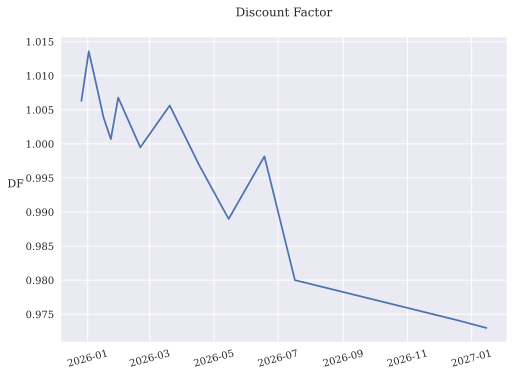

In [ ]:
import matplotlib.pyplot as plt

plt.title("Discount Factor", y=1.05)      # Title slightly above the plot.
plt.plot(processed_maturites, DFs)        # Plot DF(T) against each expiration date.
plt.grid(True)                            # Add grid for readability.
plt.ylabel("DF", rotation=0, labelpad=10) # Y-axis label.
plt.xticks(rotation=15)                   # Rotate dates so they don’t overlap.
plt.show()                                # Display the figure.


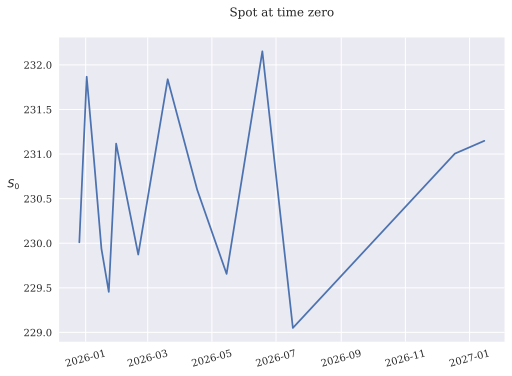

In [ ]:
import matplotlib.pyplot as plt

plt.title("Spot at time zero", y=1.05)       # Plot title.
plt.plot(processed_maturites, Ss)            # Plot the estimated S(T) (intercept) by expiration date.
plt.grid(True)                               # Add grid.
plt.ylabel(r"$S_0$", rotation=0, labelpad=10)# Y-axis label (math formatting).
plt.xticks(rotation=15)                      # Rotate dates for readability.
plt.show()                                   # Show the plot.


### As you (first hand) see, yh_df can be a challenging business. We see some unexpected behaviour right? Why is this happening? let's check our samples

In [ ]:
DFs = []                 # Store DF(T) estimates.
Ss = []                  # Store S(T) estimates.
processed_maturites = [] # Store maturities that worked.

for maturity in maturities:                       # Loop over each expiration date.
    try:
        DF, S = put_call_regression(grouped_option_chain, maturity, 25, verbose=True)
        # Run the regression and print details (verbose=True).

        DFs.append(DF)                            # Save DF(T).
        Ss.append(S)                              # Save S(T).
        processed_maturites.append(maturity)      # Save the maturity processed successfully.
    except:
        pass                                      # Skip maturities where regression fails.


2025-12-26T00:00:00.000000000 : 17 strikes | DF: 1.0063078317621488 | S: 230.01057469180617
2026-01-02T00:00:00.000000000 : 13 strikes | DF: 1.0135760425183955 | S: 231.86686937857684
2026-01-09T00:00:00.000000000 : 6 strikes | DF: 1.0088235294117667 | S: 230.9253431372554
2026-01-16T00:00:00.000000000 : 20 strikes | DF: 1.0039067092651763 | S: 229.93874281150178
2026-01-23T00:00:00.000000000 : 8 strikes | DF: 1.0006948853615534 | S: 229.45466490299862
2026-01-30T00:00:00.000000000 : 6 strikes | DF: 1.006778378378377 | S: 231.11689189189153
2026-02-20T00:00:00.000000000 : 11 strikes | DF: 0.999486486486487 | S: 229.87310810810814
2026-03-20T00:00:00.000000000 : 14 strikes | DF: 1.0056260330578501 | S: 231.83854634002316
2026-04-17T00:00:00.000000000 : 6 strikes | DF: 0.996875 | S: 230.60104166666665
2026-05-15T00:00:00.000000000 : 6 strikes | DF: 0.9889786585365832 | S: 229.6561737804872
2026-06-18T00:00:00.000000000 : 7 strikes | DF: 0.9981628959276022 | S: 232.15216548157738
2026-07-

### Something seems to happen in "2026-01-16" right?

In [ ]:
expiration_date = "2026-01-16"          # Choose one specific expiration date to analyze.
volume_filter = 25                      # Minimum volume threshold (liquidity filter).

calls = grouped_option_chain.loc[(expiration_date, "C"), ["mid_price", "volume"]]
# Select call options ("C") for this expiration, keeping only mid_price and volume.

puts  = grouped_option_chain.loc[(expiration_date, "P"), ["mid_price", "volume"]]
# Select put options ("P") for this expiration, keeping only mid_price and volume.

calls = calls[calls["volume"] > volume_filter]
# Keep only calls with volume greater than 25.

puts  = puts[puts["volume"] > volume_filter]
# Keep only puts with volume greater than 25.

joined_df = calls.join(puts, how="inner", lsuffix="_call", rsuffix="_put")
# Join calls and puts by strike (the index). "inner" keeps only strikes that exist in both.

joined_df["call_minus_put"] = joined_df["mid_price_call"] - joined_df["mid_price_put"]
# Compute C(K,T) - P(K,T) for each strike.

joined_df.head()                         # Show the first rows to inspect the matched strikes.


mid_price_call  volume_call  mid_price_put  volume_put  call_minus_put
strike                                                                        
160.0           69.275         32.0          0.070       578.0          69.205
170.0           59.325         47.0          0.115      1996.0          59.210
175.0           54.400         36.0          0.145      1239.0          54.255
180.0           49.425         40.0          0.165      1014.0          49.260
190.0           39.325        232.0          0.235       387.0          39.090

In [ ]:
option_chain["expiration_date"] = pd.to_datetime(option_chain["expiration_date"])
# Convert expiration_date to datetime so we can use .dt (date-time) operations.

sorted(option_chain["expiration_date"].dt.strftime("%Y-%m-%d").unique())[:20]
# Get the unique expiration dates, format them as YYYY-MM-DD strings, sort them, and show the first 20.


['2025-12-26',
 '2026-01-02',
 '2026-01-09',
 '2026-01-16',
 '2026-01-23',
 '2026-01-30',
 '2026-02-20',
 '2026-03-20',
 '2026-04-17',
 '2026-05-15',
 '2026-06-18',
 '2026-07-17',
 '2026-08-21',
 '2026-09-18',
 '2026-12-18',
 '2027-01-15',
 '2027-06-17',
 '2027-12-17',
 '2028-01-21',
 '2028-06-16']

In [ ]:
joined_df

mid_price_call  volume_call  mid_price_put  volume_put  call_minus_put
strike                                                                        
160.0           69.275         32.0          0.070       578.0          69.205
170.0           59.325         47.0          0.115      1996.0          59.210
175.0           54.400         36.0          0.145      1239.0          54.255
180.0           49.425         40.0          0.165      1014.0          49.260
190.0           39.325        232.0          0.235       387.0          39.090
195.0           34.400        244.0          0.305       201.0          34.095
200.0           29.550        192.0          0.395      1681.0          29.155
205.0           24.675         32.0          0.575      2345.0          24.100
210.0           20.125         57.0          0.905      1981.0          19.220
215.0           15.650        107.0          1.520      2689.0          14.130
220.0           11.725        284.0          2.570      1355.0           9.155
225.0            8.325       1771.0          4.075      1703.0           4.250
230.0            5.550       7025.0          6.400       760.0          -0.850
235.0            3.450       7576.0          9.375       105.0          -5.925
240.0            2.025       6206.0         12.950       119.0         -10.925
245.0            1.140       3925.0         17.050        30.0         -15.910
255.0            0.375       1902.0         26.450        26.0         -26.075
265.0            0.160        704.0         36.425        50.0         -36.265
275.0            0.085        225.0         46.375        37.0         -46.290
360.0            0.005         34.0        131.500        66.0        -131.495

### Here we go, so we found that mid_price has a zero value. How can we fix this? Well we can surely check that mid_price is greater than zero!

In [ ]:
def put_call_regression(grouped_df, expiration_date, volume_filter, verbose=False):
    """
    inputs:
    grouped_df: yh_dfframe with multi-index [expiration_date, option_type, strike]
    expiration_date: one maturity date
    volume_filter: minimum volume required

    output:
    DF_T, S_T: Discount Factor and S coefficient from the Put-Call parity regression
    """

    calls = grouped_df.loc[(expiration_date, "C"), ["mid_price", "volume"]]
    # Select call options for this expiration (by strike), keeping mid_price and volume.

    puts  = grouped_df.loc[(expiration_date, "P"), ["mid_price", "volume"]]
    # Select put options for this expiration (by strike), keeping mid_price and volume.

    calls = calls.loc[(calls.volume > volume_filter) & (calls.mid_price > 0)]
    # Keep only calls with enough volume and a positive mid price.

    puts  = puts.loc[(puts.volume > volume_filter) & (puts.mid_price > 0)]
    # Keep only puts with enough volume and a positive mid price.

    joined_df = calls.join(puts, how="inner", lsuffix="_call", rsuffix="_put")
    # Match calls and puts by strike (inner join keeps only strikes that exist in both).

    joined_df["call_minus_put"] = joined_df.mid_price_call - joined_df.mid_price_put
    # Compute C(K,T) - P(K,T) for each matched strike.

    assert len(joined_df) > 1
    # We need at least 2 strikes to fit a straight line.

    result = np.polyfit(x=joined_df.index, y=joined_df.call_minus_put, deg=1)
    # Fit a line: (C - P) = a + b*K using strikes as x and (C-P) as y.

    DF_T = -result[0]
    # The slope b corresponds to -DF(T), so DF(T) = -b.

    S_T  = result[1]
    # The intercept a corresponds to S(T) in the parity equation.

    if verbose:
        print(expiration_date, ":", len(joined_df), "samples | DF:", DF_T, "| S_0:", S_T)
        # Print a quick summary for this maturity if verbose=True.

    return DF_T, S_T


In [ ]:
DFs = []                 # Store DF(T) estimates for each maturity.
Ss = []                  # Store S(T) (intercept) estimates for each maturity.
processed_maturites = [] # Store maturities where the regression worked.

for maturity in maturities:                     # Loop over all expiration dates.
    try:
        DF, S = put_call_regression(grouped_option_chain, maturity, 25, verbose=True)
        # Run the regression for this maturity (volume filter = 25) and print the output.

        DFs.append(DF)                          # Save the discount factor estimate.
        Ss.append(S)                            # Save the spot/intercept estimate.
        processed_maturites.append(maturity)    # Save the maturity we successfully processed.
    except:
        pass                                    # If it fails (e.g., not enough strikes), skip it.


2025-12-26T00:00:00.000000000 : 17 samples | DF: 1.0063078317621488 | S_0: 230.01057469180617
2026-01-02T00:00:00.000000000 : 13 samples | DF: 1.0135760425183955 | S_0: 231.86686937857684
2026-01-09T00:00:00.000000000 : 6 samples | DF: 1.0088235294117667 | S_0: 230.9253431372554
2026-01-16T00:00:00.000000000 : 20 samples | DF: 1.0039067092651763 | S_0: 229.93874281150178
2026-01-23T00:00:00.000000000 : 8 samples | DF: 1.0006948853615534 | S_0: 229.45466490299862
2026-01-30T00:00:00.000000000 : 6 samples | DF: 1.006778378378377 | S_0: 231.11689189189153
2026-02-20T00:00:00.000000000 : 11 samples | DF: 0.999486486486487 | S_0: 229.87310810810814
2026-03-20T00:00:00.000000000 : 14 samples | DF: 1.0056260330578501 | S_0: 231.83854634002316
2026-04-17T00:00:00.000000000 : 6 samples | DF: 0.996875 | S_0: 230.60104166666665
2026-05-15T00:00:00.000000000 : 6 samples | DF: 0.9889786585365832 | S_0: 229.6561737804872
2026-06-18T00:00:00.000000000 : 7 samples | DF: 0.9981628959276022 | S_0: 232.1

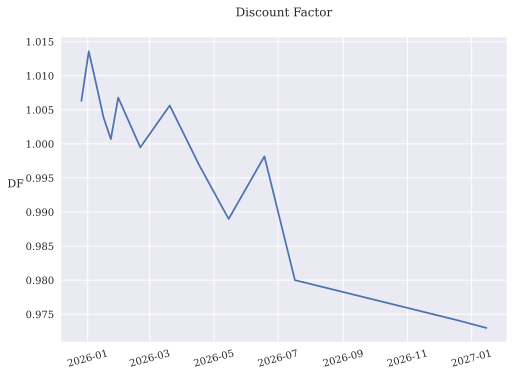

In [ ]:
plt.title("Discount Factor", y=1.05)          # Add a title (slightly above the plot).
plt.plot(processed_maturites, DFs)            # Plot DF(T) for each processed expiration date.
plt.grid(True)                                # Turn on grid lines to make it easier to read.
plt.ylabel("DF", rotation=0, labelpad=10)     # Label the y-axis as DF.
plt.xticks(rotation=15)                       # Rotate date labels so they don’t overlap.
plt.show()                                    # Display the figure.


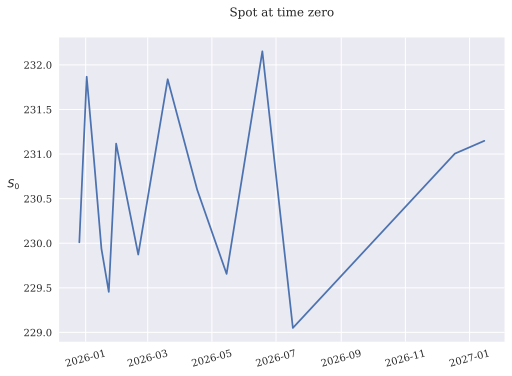

In [ ]:
plt.title("Spot at time zero", y=1.05)        # Title for the plot.
plt.plot(processed_maturites, Ss)             # Plot the estimated S(T) (intercept) by expiration date.
plt.grid(True)                                # Add grid lines.
plt.ylabel(r"$S_0$", rotation=0, labelpad=10) # Y-axis label in math format.
plt.xticks(rotation=15)                       # Rotate date labels for readability.
plt.show()                                    # Show the plot.


### Bottomline here: you will face this kind of "issue" when dealing with yh_df. Be prepared to debug and adapt your code to detect these anomalies. You can of course leave the task without the cleaning part, but as a good future quant you should question these anomalies

# Exercise 2:

### a) Using the forward prices $F(T)$ and Discount Factors $DF(T)$ obtained previously, calculate the implied volatility of each option using the  ```mid_price```. (Note that you will need to use the implied volatility calculation that you did in the Session 2 assignment)

Recall that in the Black-Scholes model, the value of a European Call option on $(S_t)_{t\geq 0}$ is given at inception by,
    $$C^{\mathrm{BS}}(S_0, K, T;\sigma) = S(T)\left(\mathcal{N}(d_{+}) - DF(T)K\mathcal{N}(d_{-})\right)$$
    $$d_{\pm} = \frac{\log\left(\frac{F(T)}{K}\right)}{\sigma\sqrt{T}} \pm\frac{\sigma\sqrt{T}}{2}$$
    
 Where $F(T)=\frac{S(T)}{DF(T)}$
  

### Remark1 : Try to optimize your code to execute efficiently
### Remark2 : Note that some mid prices might lead to arbitrage and the solution for implied volatility might not exist


### a) let us first deal with the fact that we were not able to compute $DF$ and $S$ for all expirations. To fix this we will need to apply some kind of interpolation

In [ ]:
yh_dfframe = pd.DataFrame(index=maturities)
# Create an empty yh_dfFrame indexed by all maturities (expiration dates).

yh_dfframe["DF"] = np.nan
# Add a DF column and initialize it with NaN (missing) values.

yh_dfframe["S"] = np.nan
# Add an S column and initialize it with NaN values.

yh_dfframe.loc[processed_maturites, "DF"] = DFs
# Fill DF only for maturities where the regression worked.

yh_dfframe.loc[processed_maturites, "S"] = Ss
# Fill S only for maturities where the regression worked.


    ## For simplicity we will apply linear interpolation

                  DF           S
2025-12-26  1.006308  230.010575
2026-01-02  1.013576  231.866869
2026-01-09  1.008824  230.925343
2026-01-16  1.003907  229.938743
2026-01-23  1.000695  229.454665
2026-01-30  1.006778  231.116892
2026-02-20  0.999486  229.873108
2026-03-20  1.005626  231.838546
2026-04-17  0.996875  230.601042
2026-05-15  0.988979  229.656174
2026-06-18  0.998163  232.152165
2026-07-17  0.980000  229.050000
2026-08-21  0.978045  229.701629
2026-09-18  0.976090  230.353259
2026-12-18  0.974134  231.004888
2027-01-15  0.972989  231.148179
2027-06-17  0.972989  231.148179
2027-12-17  0.972989  231.148179
2028-01-21  0.972989  231.148179
2028-06-16  0.972989  231.148179


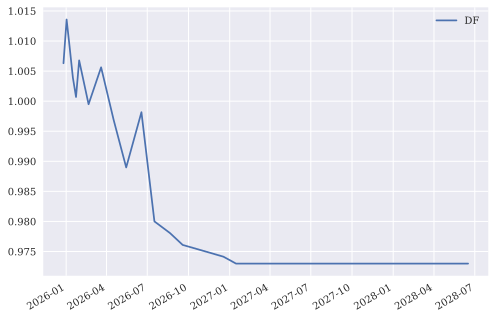

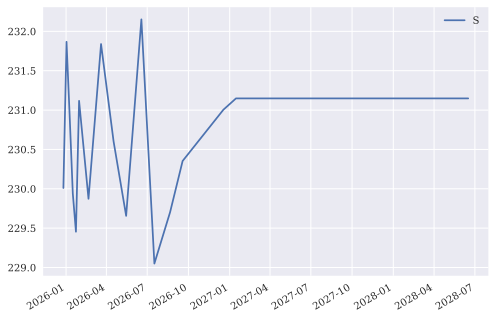

In [ ]:
interpolated_df = yh_dfframe.interpolate(method="linear", axis=0, limit_direction="both")
# Fill missing DF and S values by linear interpolation along the maturity (index).
# limit_direction="both" also fills NaNs at the start/end using the closest available values.
interpolated_df.plot(y="DF")
# Plot the interpolated discount factor curve across maturities.
interpolated_df.plot(y="S")
# Plot the interpolated S curve across maturities.
print(interpolated_df)
# Print the full table with original + interpolated values.


# Let us now fill our original option_chain yh_dfframe with $DF$ and $S$

In [ ]:
option_chain["DF"] = interpolated_df.loc[option_chain.expiration_date, "DF"].values
# For each option row, assign DF(T) by looking up its expiration_date in interpolated_df.
option_chain["S"]  = interpolated_df.loc[option_chain.expiration_date, "S"].values
# Same idea for S(T): match by expiration_date and copy the interpolated S value.
option_chain.head()
# Show the first rows to confirm DF and S were added correctly.


contractSymbol option_type expiration_date  strike     bid     ask  \
0  AMZN251226C00125000           C      2025-12-26   125.0  102.05  105.45   
1  AMZN251226C00130000           C      2025-12-26   130.0   96.95  100.45   
2  AMZN251226C00135000           C      2025-12-26   135.0   91.95   95.45   
3  AMZN251226C00140000           C      2025-12-26   140.0   86.95   90.45   
4  AMZN251226C00145000           C      2025-12-26   145.0   82.10   85.50   

   volume  openInterest  impliedVolatility  inTheMoney trade_date  mid_price  \
0     1.0            17           2.462894        True 2025-12-22     103.75   
1     1.0             8           2.261723        True 2025-12-22      98.70   
2     2.0            31           2.125005        True 2025-12-22      93.70   
3     2.0             3           1.994141        True 2025-12-22      88.70   
4     NaN             2           1.958985        True 2025-12-22      83.80   

          T         S_T      DF_T        DF           S  
0  0.009132  229.299783  1.003112  1.006308  230.010575  
1  0.009132  229.299783  1.003112  1.006308  230.010575  
2  0.009132  229.299783  1.003112  1.006308  230.010575  
3  0.009132  229.299783  1.003112  1.006308  230.010575  
4  0.009132  229.299783  1.003112  1.006308  230.010575

### We will create a smaller yh_dfframe with the columns we need to perform Black-Scholes to Implied Volatility trasform

In [ ]:
option_chain_reduced = option_chain.loc[:, ["S", "strike", "T", "option_type", "mid_price", "DF"]]
# Keep only the columns needed for the next steps (pricing / implied volatility).
option_chain_reduced.head()
# Preview the reduced yh_dfset.


S  strike         T option_type  mid_price        DF
0  230.010575   125.0  0.009132           C     103.75  1.006308
1  230.010575   130.0  0.009132           C      98.70  1.006308
2  230.010575   135.0  0.009132           C      93.70  1.006308
3  230.010575   140.0  0.009132           C      88.70  1.006308
4  230.010575   145.0  0.009132           C      83.80  1.006308

In [ ]:
### Let us now use apply function

from scipy.optimize import fsolve, brentq   # Numerical solvers (we mainly use brentq for robustness).
from scipy.stats import norm                # Normal CDF for Black–Scholes formulas.
import numpy as np                          # Numerical computing (logs, sqrt, arrays, etc.).

def BS_european_option(S0, K, sigma, CP, T, DF):
    """
    Black–Scholes option price using a discount factor DF = exp(-rT).
    CP: 'C' for call, 'P' for put
    """
    if T <= 0 or sigma <= 0:
        # Edge case: if no time left (or sigma invalid), return intrinsic value.
        if CP == "C":
            return max(S0 - K, 0.0)         # Call intrinsic value.
        else:
            return max(K * DF - S0, 0.0)    # Put intrinsic value (using discounted strike).

    vol_sqrt = sigma * np.sqrt(T)           # sigma * sqrt(T), used repeatedly in d1/d2.

    # Using DF = exp(-rT) implies K*DF is the discounted strike.
    d1 = (np.log(S0 / (K * DF)) + 0.5 * sigma * sigma * T) / vol_sqrt
    d2 = d1 - vol_sqrt

    if CP == "C":
        return S0 * norm.cdf(d1) - K * DF * norm.cdf(d2)          # Call BS price.
    else:
        return K * DF * norm.cdf(-d2) - S0 * norm.cdf(-d1)        # Put BS price.

def implied_vol(price, S0, K, T, CP, DF):
    """
    Compute implied volatility by solving: BS_price(sigma) = market_price.
    Uses brentq (a bracketed root solver). Returns NaN if no valid solution.
    """
    if price <= 0 or S0 <= 0 or K <= 0 or T <= 0 or DF <= 0:
        return np.nan                        # Basic input sanity check.

    def obj(sigma):
        return BS_european_option(S0, K, sigma, CP, T, DF) - price
        # Objective is zero when BS price matches the observed market price.

    lo, hi = 1e-6, 5.0                       # Search interval for sigma (0% to 500% annualized).

    try:
        f_lo = obj(lo)
        f_hi = obj(hi)

        if np.sign(f_lo) == np.sign(f_hi):
            return np.nan                    # No sign change => no guaranteed root in [lo, hi].

        return brentq(obj, lo, hi, maxiter=200)
        # Find sigma that sets obj(sigma)=0.

    except Exception:
        return np.nan                        # If solver fails, return NaN.

def apply_func(x):
    # x is a row array: [S, strike, T, option_type, mid_price, DF]
    S0, K, T, CP, mid, DF = x                # Unpack the row values.
    return implied_vol(mid, S0, K, T, CP, DF)# Return implied volatility for that option.


In [ ]:
import time
start_time = time.time()
# Start a timer so we can measure how long the IV computation takes.

option_chain["IV"] = option_chain_reduced.apply(apply_func, axis=1, raw=True)
# Apply apply_func row-by-row (axis=1) to compute implied volatility for each option.
# raw=True passes each row as a NumPy array (faster than a pandas Series).

print("IV computation took", time.time() - start_time, "seconds")
# Print the elapsed time.

option_chain[["expiration_date", "strike", "option_type", "mid_price", "DF", "S", "T", "IV"]].head()
# Show a quick preview of the main columns plus the computed implied volatility.


IV computation took 1.0028529167175293 seconds


expiration_date  strike option_type  mid_price        DF           S  \
0      2025-12-26   125.0           C     103.75  1.006308  230.010575   
1      2025-12-26   130.0           C      98.70  1.006308  230.010575   
2      2025-12-26   135.0           C      93.70  1.006308  230.010575   
3      2025-12-26   140.0           C      88.70  1.006308  230.010575   
4      2025-12-26   145.0           C      83.80  1.006308  230.010575   

          T  IV  
0  0.009132 NaN  
1  0.009132 NaN  
2  0.009132 NaN  
3  0.009132 NaN  
4  0.009132 NaN

# Python for Finance (2nd ed.)

**Mastering yh_df-Driven Finance**

&copy; Dr. Yves J. Hilpisch | The Python Quants GmbH

<img src="https://hilpisch.com/images/py4fi_2nd_shadow.png" width="300px" align="left">

# Financial Time Series

In [ ]:
import numpy as np
import pandas as pd
from pylab import mpl, plt
plt.style.use('seaborn-v0_8')
mpl.rcParams['font.family'] = 'serif'
%config InlineBackend.figure_format = 'svg'

In [ ]:
import warnings
warnings.simplefilter('ignore')

## Financial yh_df

### yh_df Import

In [ ]:
import os

# Local CSV used throughout this notebook (original path from the book repo).
# If the original relative path is not writable in your environment, we fall back to ./source/
_default_filename = '../../source/tr_eikon_eod_yh_df.csv'
_fallback_filename = 'source/tr_eikon_eod_yh_df.csv'

try:
    os.makedirs(os.path.dirname(_default_filename), exist_ok=True)
    filename = _default_filename
except Exception:
    os.makedirs(os.path.dirname(_fallback_filename), exist_ok=True)
    filename = _fallback_filename

# If the CSV is not present, create it from Yahoo Finance (yfinance) with yh_df through 2025.
# This keeps the rest of the notebook unchanged and makes "Run All" work out of the box.
if not os.path.exists(filename):
    try:
        try:
            import yfinance as yf
        except ImportError as e:
            raise RuntimeError(
                "yfinance is required to download the 2025-updated yh_dfset. "
                "Install it with: pip install yfinance"
            ) from e

        # Map Yahoo tickers to the RIC-style column names used in the book.
        # (The original Eikon file contains these instruments in this order.)
        tickers_map = {
            'AAPL': 'AAPL.O',
            'MSFT': 'MSFT.O',
            'INTC': 'INTC.O',
            'AMZN': 'AMZN.O',
            'GS': 'GS.N',
            'SPY': 'SPY',
            '^GSPC': '.SPX',
            '^VIX': '.VIX',
            'EURUSD=X': 'EUR=',
            'GC=F': 'XAU=',
            'GDX': 'GDX',
            'GLD': 'GLD',
        }

        # End is exclusive; using 2026-01-01 ensures coverage through the end of 2025.
        start = '2010-01-01'
        end = '2026-01-01'

        raw_yf = yf.download(list(tickers_map.keys()),
                             start=start, end=end,
                             auto_adjust=False,
                             progress=False)

        # Prefer Adj Close; fall back to Close where Adj Close is missing.
        if isinstance(raw_yf.columns, pd.MultiIndex):
            if 'Adj Close' in raw_yf.columns.levels[0]:
                adj = raw_yf['Adj Close'].copy()
                close = raw_yf['Close'].copy() if 'Close' in raw_yf.columns.levels[0] else None
                price = adj
                if close is not None:
                    for col in price.columns:
                        if price[col].isna().all() and col in close.columns:
                            price[col] = close[col]
            else:
                price = raw_yf['Close'].copy()
        else:
            # Single ticker fallback (should not usually happen here)
            price = raw_yf.copy()

        # Rename columns to the expected RIC-like names and keep the canonical order.
        price = price.rename(columns=tickers_map)
        price = price[list(tickers_map.values())]
        # If download returned no usable yh_df (e.g., no internet), trigger synthetic fallback.
        if price.empty or price.dropna(how='all').empty:
            raise RuntimeError('Downloaded price yh_df is empty or all-NaN.')


        # Save for the rest of the notebook.
        price.to_csv(filename)

        print(f'Created {filename} from Yahoo Finance with {price.shape[0]} rows and {price.shape[1]} columns.')
    except Exception as e:
        # Offline / rate-limit / missing dependency / temporary failures: create a synthetic file so the notebook still runs.
        print('WARNING: Could not download yh_df from Yahoo Finance (yfinance).')
        print('Falling back to synthetic yh_df so the notebook can run end-to-end.')
        print('Error was:', repr(e))

        tickers = ['AAPL.O', 'MSFT.O', 'INTC.O', 'AMZN.O', 'GS.N', 'SPY', '.SPX', '.VIX', 'EUR=', 'XAU=', 'GDX', 'GLD']
        dates = pd.date_range('2010-01-01', '2025-12-31', freq='B')
        rng = np.random.default_rng(42)

        synth = pd.DataFrame(index=dates)
        for t in tickers:
            # Random-walk in log space to keep values positive
            synth[t] = 100 * np.exp(np.cumsum(rng.normal(loc=0.0002, scale=0.01, size=len(dates))))
        synth.to_csv(filename)
        print(f'Created synthetic {filename} with {synth.shape[0]} rows and {synth.shape[1]} columns.')

In [ ]:
f = open(filename, 'r')  
f.readlines()[:5]  

['Date,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD\n',
 '2010-01-01,,,,,,,,,1.4389938116073608,,,\n',
 '2010-01-04,6.4183831214904785,23.13006019592285,13.519426345825195,6.695000171661377,130.64154052734375,85.0279541015625,1132.989990234375,20.040000915527344,1.4423978328704834,1117.699951171875,41.39030838012695,109.80000305175781\n',
 '2010-01-05,6.429479598999023,23.137531280517578,13.512956619262695,6.734499931335449,132.95123291015625,85.25304412841797,1136.52001953125,19.350000381469727,1.4365959167480469,1118.0999755859375,41.78937530517578,109.69999694824219\n',
 '2010-01-06,6.327210903167725,22.995542526245117,13.46762752532959,6.612500190734863,131.5321502685547,85.31306457519531,1137.1400146484375,19.15999984741211,1.4404033422470093,1135.9000244140625,42.80438995361328,111.51000213623047\n']

In [ ]:
yh_df = pd.read_csv(filename,  
                   index_col=0, 
                   parse_dates=True)  

In [ ]:
yh_df.info()  

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4169 entries, 2010-01-01 to 2025-12-29
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL.O  4021 non-null   float64
 1   MSFT.O  4021 non-null   float64
 2   INTC.O  4021 non-null   float64
 3   AMZN.O  4021 non-null   float64
 4   GS.N    4021 non-null   float64
 5   SPY     4021 non-null   float64
 6   .SPX    4021 non-null   float64
 7   .VIX    4022 non-null   float64
 8   EUR=    4163 non-null   float64
 9   XAU=    4021 non-null   float64
 10  GDX     4021 non-null   float64
 11  GLD     4021 non-null   float64
dtypes: float64(12)
memory usage: 423.4 KB


In [ ]:
yh_df.head()  

AAPL.O     MSFT.O     INTC.O  AMZN.O        GS.N        SPY  \
Date                                                                        
2010-01-01       NaN        NaN        NaN     NaN         NaN        NaN   
2010-01-04  6.418383  23.130060  13.519426  6.6950  130.641541  85.027954   
2010-01-05  6.429480  23.137531  13.512957  6.7345  132.951233  85.253044   
2010-01-06  6.327211  22.995543  13.467628  6.6125  131.532150  85.313065   
2010-01-07  6.315514  22.756388  13.338133  6.5000  134.106049  85.673195   

                   .SPX       .VIX      EUR=         XAU=        GDX  \
Date                                                                   
2010-01-01          NaN        NaN  1.438994          NaN        NaN   
2010-01-04  1132.989990  20.040001  1.442398  1117.699951  41.390308   
2010-01-05  1136.520020  19.350000  1.436596  1118.099976  41.789375   
2010-01-06  1137.140015  19.160000  1.440403  1135.900024  42.804390   
2010-01-07  1141.689941  19.059999  1.431803  1133.099976  42.596195   

                   GLD  
Date                    
2010-01-01         NaN  
2010-01-04  109.800003  
2010-01-05  109.699997  
2010-01-06  111.510002  
2010-01-07  110.820000

In [ ]:
yh_df.tail()  

AAPL.O      MSFT.O     INTC.O      AMZN.O        GS.N  \
Date                                                                    
2025-12-22  270.970001  484.920013  36.369999  228.429993  899.000000   
2025-12-23  272.359985  486.850006  36.349998  232.139999  901.710022   
2025-12-24  273.809998  488.019989  36.160000  232.380005  910.780029   
2025-12-26  273.399994  487.709991  36.200001  232.520004  907.039978   
2025-12-29         NaN         NaN        NaN         NaN         NaN   

                   SPY         .SPX   .VIX      EUR=         XAU=        GDX  \
Date                                                                           
2025-12-22  684.830017  6878.490234  14.08  1.170809  4444.600098  90.180000   
2025-12-23  687.960022  6909.790039  14.00  1.176595  4482.799805  90.269997   
2025-12-24  690.380005  6932.049805  13.47  1.179551  4480.600098  89.699997   
2025-12-26  690.309998  6929.939941  13.60  1.178536  4529.100098  91.290001   
2025-12-29         NaN          NaN  14.96  1.178134  4415.600098        NaN   

                   GLD  
Date                    
2025-12-22  408.230011  
2025-12-23  413.640015  
2025-12-24  411.929993  
2025-12-26  416.739990  
2025-12-29         NaN

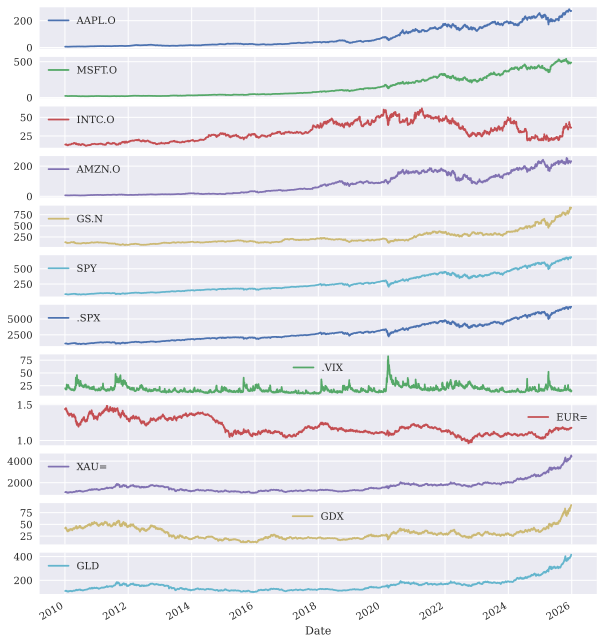

In [ ]:
yh_df.plot(figsize=(10, 12), subplots=True);  

In [ ]:
instruments = ['Apple Stock', 'Microsoft Stock',
               'Intel Stock', 'Amazon Stock', 'Goldman Sachs Stock',
               'SPDR S&P 500 ETF Trust', 'S&P 500 Index',
               'VIX Volatility Index', 'EUR/USD Exchange Rate',
               'Gold Price', 'VanEck Vectors Gold Miners ETF',
               'SPDR Gold Trust']

In [ ]:
for ric, name in zip(yh_df.columns, instruments):
    print('{:8s} | {}'.format(ric, name))

AAPL.O   | Apple Stock
MSFT.O   | Microsoft Stock
INTC.O   | Intel Stock
AMZN.O   | Amazon Stock
GS.N     | Goldman Sachs Stock
SPY      | SPDR S&P 500 ETF Trust
.SPX     | S&P 500 Index
.VIX     | VIX Volatility Index
EUR=     | EUR/USD Exchange Rate
XAU=     | Gold Price
GDX      | VanEck Vectors Gold Miners ETF
GLD      | SPDR Gold Trust


### Summary Statistics

In [ ]:
yh_df.info()  

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4169 entries, 2010-01-01 to 2025-12-29
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL.O  4021 non-null   float64
 1   MSFT.O  4021 non-null   float64
 2   INTC.O  4021 non-null   float64
 3   AMZN.O  4021 non-null   float64
 4   GS.N    4021 non-null   float64
 5   SPY     4021 non-null   float64
 6   .SPX    4021 non-null   float64
 7   .VIX    4022 non-null   float64
 8   EUR=    4163 non-null   float64
 9   XAU=    4021 non-null   float64
 10  GDX     4021 non-null   float64
 11  GLD     4021 non-null   float64
dtypes: float64(12)
memory usage: 423.4 KB


In [ ]:
yh_df.describe().round(2)  

AAPL.O   MSFT.O   INTC.O   AMZN.O     GS.N      SPY     .SPX     .VIX  \
count  4021.00  4021.00  4021.00  4021.00  4021.00  4021.00  4021.00  4022.00   
mean     77.37   149.38    30.17    80.42   230.00   268.49  2942.07    18.41   
std      74.87   145.21    12.44    68.95   154.63   155.66  1487.74     6.87   
min       5.76    17.35    11.70     5.43    67.49    77.36  1022.58     9.14   
25%      18.23    30.83    18.99    15.48   128.42   146.62  1805.09    13.77   
50%      38.86    78.84    27.96    59.45   176.29   228.29  2584.59    16.66   
75%     142.88   251.16    41.22   139.98   302.57   386.97  4076.57    21.10   
max     286.19   541.06    62.08   254.00   911.03   690.38  6932.05    82.69   

          EUR=     XAU=      GDX      GLD  
count  4163.00  4021.00  4021.00  4021.00  
mean      1.19  1662.83    31.03   157.09  
std       0.11   582.69    12.69    52.14  
min       0.96  1050.80    11.31   100.50  
25%       1.10  1268.50    20.97   121.11  
50%       1.16  1506.20    28.17   143.66  
75%       1.29  1830.20    38.49   172.07  
max       1.48  4529.10    91.29   416.74

In [ ]:
yh_df.mean()  

AAPL.O      77.365002
MSFT.O     149.383242
INTC.O      30.166333
AMZN.O      80.416714
GS.N       229.996106
SPY        268.491312
.SPX      2942.073692
.VIX        18.414940
EUR=         1.186457
XAU=      1662.827629
GDX         31.025990
GLD        157.087846
dtype: float64

In [ ]:
yh_df.aggregate([min,  
                np.mean,  
                np.std,  
                np.median,  
                max]  
).round(2)

AAPL.O  MSFT.O  INTC.O  AMZN.O    GS.N     SPY     .SPX   .VIX  EUR=  \
min       5.76   17.35   11.70    5.43   67.49   77.36  1022.58   9.14  0.96   
mean     77.37  149.38   30.17   80.42  230.00  268.49  2942.07  18.41  1.19   
std      74.87  145.21   12.44   68.95  154.63  155.66  1487.74   6.87  0.11   
median   38.86   78.84   27.96   59.45  176.29  228.29  2584.59  16.66  1.16   
max     286.19  541.06   62.08  254.00  911.03  690.38  6932.05  82.69  1.48   

           XAU=    GDX     GLD  
min     1050.80  11.31  100.50  
mean    1662.83  31.03  157.09  
std      582.69  12.69   52.14  
median  1506.20  28.17  143.66  
max     4529.10  91.29  416.74

### Changes Over Time

In [ ]:
yh_df.diff().head()  

AAPL.O    MSFT.O    INTC.O  AMZN.O      GS.N      SPY      .SPX  \
Date                                                                            
2010-01-01       NaN       NaN       NaN     NaN       NaN      NaN       NaN   
2010-01-04       NaN       NaN       NaN     NaN       NaN      NaN       NaN   
2010-01-05  0.011096  0.007471 -0.006470  0.0395  2.309692  0.22509  3.530029   
2010-01-06 -0.102269 -0.141989 -0.045329 -0.1220 -1.419083  0.06002  0.619995   
2010-01-07 -0.011697 -0.239155 -0.129495 -0.1125  2.573898  0.36013  4.549927   

                .VIX      EUR=       XAU=       GDX       GLD  
Date                                                           
2010-01-01       NaN       NaN        NaN       NaN       NaN  
2010-01-04       NaN  0.003404        NaN       NaN       NaN  
2010-01-05 -0.690001 -0.005802   0.400024  0.399067 -0.100006  
2010-01-06 -0.190001  0.003807  17.800049  1.015015  1.810005  
2010-01-07 -0.100000 -0.008600  -2.800049 -0.208195 -0.690002

In [ ]:
yh_df.diff().mean()  

AAPL.O    0.077474
MSFT.O    0.120294
INTC.O    0.003646
AMZN.O    0.046697
GS.N      0.222254
SPY       0.161463
.SPX      1.563239
.VIX     -0.022652
EUR=     -0.000070
XAU=      0.752995
GDX       0.011227
GLD       0.067745
dtype: float64

In [ ]:
yh_df.pct_change().round(3).head()  

AAPL.O  MSFT.O  INTC.O  AMZN.O   GS.N    SPY   .SPX   .VIX   EUR=  \
Date                                                                            
2010-01-01     NaN     NaN     NaN     NaN    NaN    NaN    NaN    NaN    NaN   
2010-01-04     NaN     NaN     NaN     NaN    NaN    NaN    NaN    NaN  0.002   
2010-01-05   0.002   0.000  -0.000   0.006  0.018  0.003  0.003 -0.034 -0.004   
2010-01-06  -0.016  -0.006  -0.003  -0.018 -0.011  0.001  0.001 -0.010  0.003   
2010-01-07  -0.002  -0.010  -0.010  -0.017  0.020  0.004  0.004 -0.005 -0.006   

             XAU=    GDX    GLD  
Date                             
2010-01-01    NaN    NaN    NaN  
2010-01-04    NaN    NaN    NaN  
2010-01-05  0.000  0.010 -0.001  
2010-01-06  0.016  0.024  0.016  
2010-01-07 -0.002 -0.005 -0.006

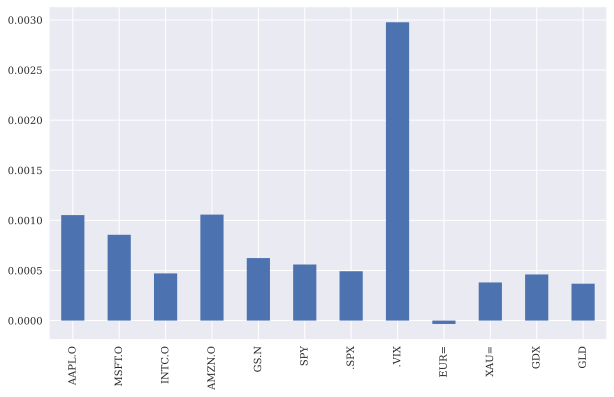

In [ ]:
yh_df.pct_change().mean().plot(kind='bar', figsize=(10, 6));  

In [ ]:
rets = np.log(yh_df / yh_df.shift(1))  

In [ ]:
rets.head().round(3)  

AAPL.O  MSFT.O  INTC.O  AMZN.O   GS.N    SPY   .SPX   .VIX   EUR=  \
Date                                                                            
2010-01-01     NaN     NaN     NaN     NaN    NaN    NaN    NaN    NaN    NaN   
2010-01-04     NaN     NaN     NaN     NaN    NaN    NaN    NaN    NaN  0.002   
2010-01-05   0.002   0.000  -0.000   0.006  0.018  0.003  0.003 -0.035 -0.004   
2010-01-06  -0.016  -0.006  -0.003  -0.018 -0.011  0.001  0.001 -0.010  0.003   
2010-01-07  -0.002  -0.010  -0.010  -0.017  0.019  0.004  0.004 -0.005 -0.006   

             XAU=    GDX    GLD  
Date                             
2010-01-01    NaN    NaN    NaN  
2010-01-04    NaN    NaN    NaN  
2010-01-05  0.000  0.010 -0.001  
2010-01-06  0.016  0.024  0.016  
2010-01-07 -0.002 -0.005 -0.006

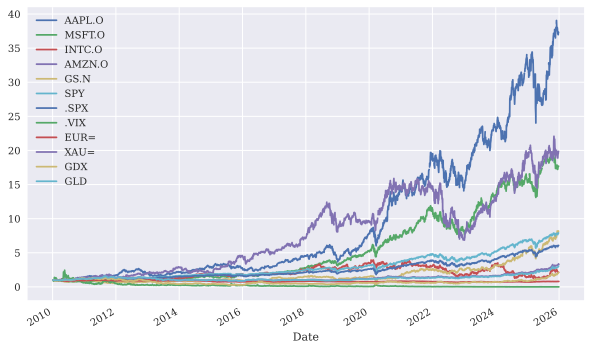

In [ ]:
rets.cumsum().apply(np.exp).plot(figsize=(10, 6));  

### Resampling

In [ ]:
yh_df.resample('1w', label='right').last().head()  

AAPL.O     MSFT.O     INTC.O  AMZN.O        GS.N        SPY  \
Date                                                                        
2010-01-03       NaN        NaN        NaN     NaN         NaN        NaN   
2010-01-10  6.357501  22.913324  13.487055  6.6760  131.569962  85.958328   
2010-01-17  6.176055  23.062798  13.467628  6.3570  124.701233  85.260544   
2010-01-24  5.930729  21.642860  12.891368  6.0715  116.330460  81.936852   
2010-01-31  5.760081  21.059935  12.561153  6.2705  112.254463  80.571373   

                   .SPX       .VIX      EUR=         XAU=        GDX  \
Date                                                                   
2010-01-03          NaN        NaN  1.438994          NaN        NaN   
2010-01-10  1144.979980  18.129999  1.441109  1138.199951  43.238174   
2010-01-17  1136.030029  17.910000  1.439097  1130.099976  41.138729   
2010-01-24  1091.760010  27.309999  1.414107  1089.199951  37.989563   
2010-01-31  1073.869995  24.620001  1.386693  1083.000000  35.326206   

                   GLD  
Date                    
2010-01-03         NaN  
2010-01-10  111.370003  
2010-01-17  110.860001  
2010-01-24  107.169998  
2010-01-31  105.959999

In [ ]:
yh_df.resample('1m', label='right').last().head()  

AAPL.O     MSFT.O     INTC.O  AMZN.O        GS.N        SPY  \
Date                                                                        
2010-01-31  5.760081  21.059935  12.561153  6.2705  112.254463  80.571373   
2010-02-28  6.136768  21.526321  13.399142  5.9200  118.278259  83.084747   
2010-03-31  7.047895  21.991844  14.547829  6.7885  129.081055  88.142921   
2010-04-30  7.830361  22.930378  14.906786  6.8550  109.843300  89.506516   
2010-05-31  7.704100  19.458847  14.078608  6.2730  109.405136  82.394814   

                   .SPX       .VIX      EUR=         XAU=        GDX  \
Date                                                                   
2010-01-31  1073.869995  24.620001  1.386693  1083.000000  35.326206   
2010-02-28  1104.489990  19.500000  1.363104  1118.300049  38.076305   
2010-03-31  1169.430054  17.590000  1.350804  1113.300049  38.527431   
2010-04-30  1186.689941  22.049999  1.329805  1180.099976  43.819412   
2010-05-31  1089.410034  32.070000  1.228788  1212.199951  43.255520   

                   GLD  
Date                    
2010-01-31  105.959999  
2010-02-28  109.430000  
2010-03-31  108.949997  
2010-04-30  115.360001  
2010-05-31  118.879997

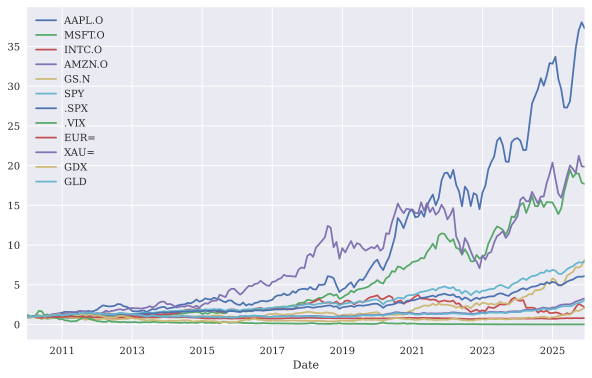

In [ ]:
rets.cumsum().apply(np.exp). resample('1m', label='right').last(
                          ).plot(figsize=(10, 6));

## Rolling Statistics

In [ ]:
sym = 'AAPL.O'

In [ ]:
yh_df = pd.DataFrame(yh_df[sym]).dropna()

In [ ]:
yh_df.tail()

AAPL.O
Date                  
2025-12-19  273.670013
2025-12-22  270.970001
2025-12-23  272.359985
2025-12-24  273.809998
2025-12-26  273.399994

### An Overview

In [ ]:
window = 20  

In [ ]:
yh_df['min'] = yh_df[sym].rolling(window=window).min()  

In [ ]:
yh_df['mean'] = yh_df[sym].rolling(window=window).mean()  

In [ ]:
yh_df['std'] = yh_df[sym].rolling(window=window).std()  

In [ ]:
yh_df['median'] = yh_df[sym].rolling(window=window).median()  

In [ ]:
yh_df['max'] = yh_df[sym].rolling(window=window).max()  

In [ ]:
yh_df['ewma'] = yh_df[sym].ewm(halflife=0.5, min_periods=window).mean()  

In [ ]:
yh_df.dropna().head()

AAPL.O       min      mean       std    median       max  \
Date                                                                     
2010-02-01  5.840157  5.760081  6.210125  0.196028  6.260630  6.449275   
2010-02-02  5.874044  5.760081  6.182908  0.203247  6.237386  6.449275   
2010-02-03  5.975115  5.760081  6.160190  0.199596  6.232138  6.449275   
2010-02-04  5.759781  5.759781  6.131819  0.214386  6.203047  6.449275   
2010-02-05  5.862050  5.759781  6.109145  0.217887  6.176205  6.449275   

                ewma  
Date                  
2010-02-01  5.837386  
2010-02-02  5.864879  
2010-02-03  5.947556  
2010-02-04  5.806725  
2010-02-05  5.848218

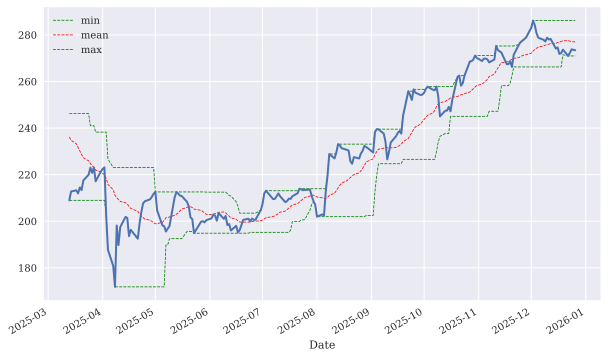

In [ ]:
ax = yh_df[['min', 'mean', 'max']].iloc[-200:].plot(
    figsize=(10, 6), style=['g--', 'r--', 'g--'], lw=0.8)  
yh_df[sym].iloc[-200:].plot(ax=ax, lw=2.0);  

### A Technical Analysis Example

In [ ]:
yh_df['SMA1'] = yh_df[sym].rolling(window=42).mean()  

In [ ]:
yh_df['SMA2'] = yh_df[sym].rolling(window=252).mean()  

In [ ]:
yh_df[[sym, 'SMA1', 'SMA2']].tail()

AAPL.O        SMA1        SMA2
Date                                          
2025-12-19  273.670013  272.803143  231.382698
2025-12-22  270.970001  273.107198  231.478083
2025-12-23  272.359985  273.417470  231.572109
2025-12-24  273.809998  273.685196  231.653322
2025-12-26  273.399994  273.800680  231.729828

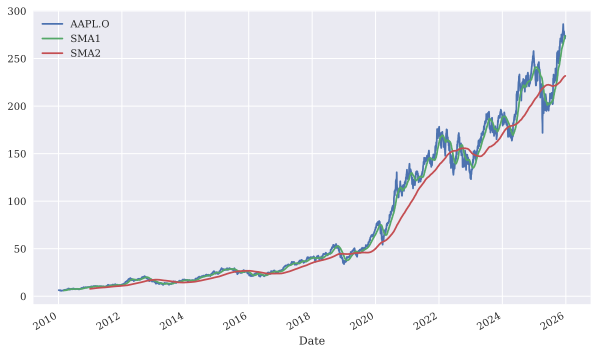

In [ ]:
yh_df[[sym, 'SMA1', 'SMA2']].plot(figsize=(10, 6));  

In [ ]:
yh_df.dropna(inplace=True)  

In [ ]:
yh_df['positions'] = np.where(yh_df['SMA1'] > yh_df['SMA2'],  
                             1,  
                             -1)  

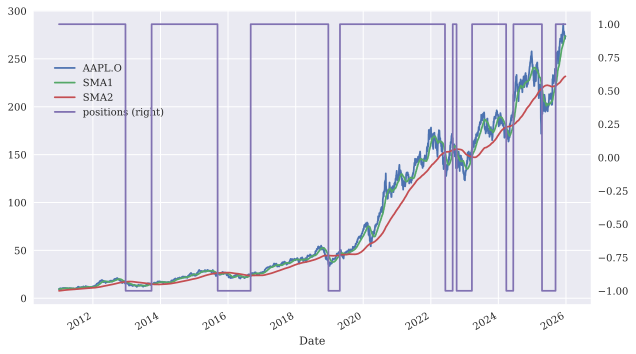

In [ ]:
ax = yh_df[[sym, 'SMA1', 'SMA2', 'positions']].plot(figsize=(10, 6),
                                              secondary_y='positions')
ax.get_legend().set_bbox_to_anchor((0.25, 0.85));

## Regression Analysis

### The yh_df

In [ ]:
# EOD yh_df (loaded from the CSV defined above)
raw = pd.read_csv(filename, index_col=0, parse_dates=True)


In [ ]:
yh_df = raw[['.SPX', '.VIX']].dropna()

In [ ]:
yh_df.tail()

.SPX   .VIX
Date                          
2025-12-19  6834.500000  14.91
2025-12-22  6878.490234  14.08
2025-12-23  6909.790039  14.00
2025-12-24  6932.049805  13.47
2025-12-26  6929.939941  13.60

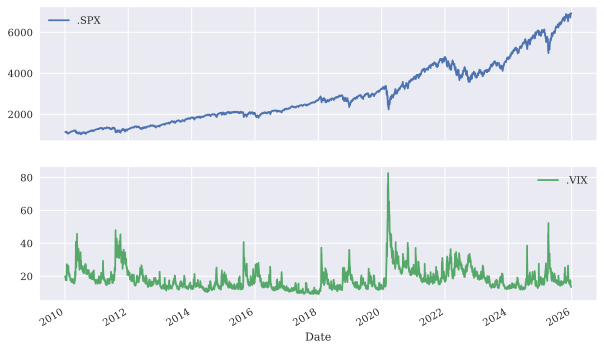

In [ ]:
yh_df.plot(subplots=True, figsize=(10, 6));

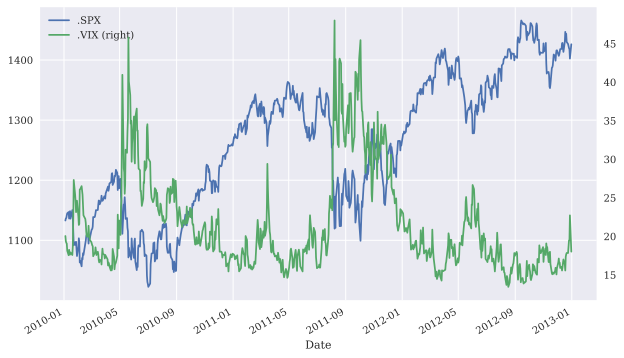

In [ ]:
yh_df.loc[:'2012-12-31'].plot(secondary_y='.VIX', figsize=(10, 6));  

### Log Returns

In [ ]:
rets = np.log(yh_df / yh_df.shift(1)) 

In [ ]:
rets.head()

.SPX      .VIX
Date                          
2010-01-04       NaN       NaN
2010-01-05  0.003111 -0.035038
2010-01-06  0.000545 -0.009868
2010-01-07  0.003993 -0.005233
2010-01-08  0.002878 -0.050024

In [ ]:
rets.dropna(inplace=True)

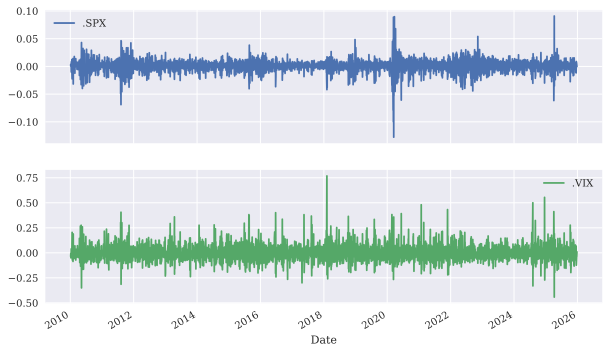

In [ ]:
rets.plot(subplots=True, figsize=(10, 6));

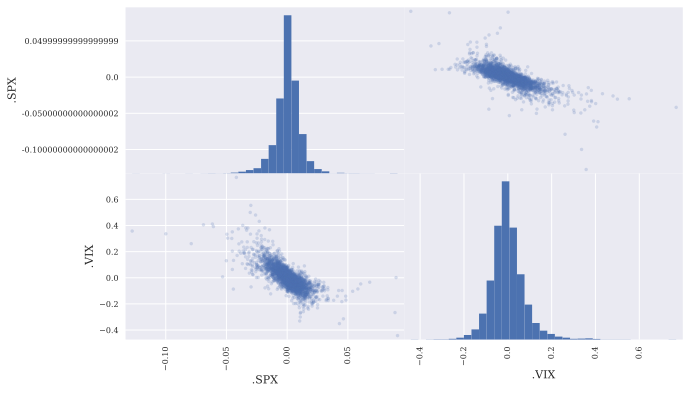

In [ ]:
pd.plotting.scatter_matrix(rets,  
                           alpha=0.2,  
                           diagonal='hist',  
                           hist_kwds={'bins': 35},  
                           figsize=(10, 6));

### OLS Regression

In [ ]:
reg = np.polyfit(rets['.SPX'], rets['.VIX'], deg=1)  

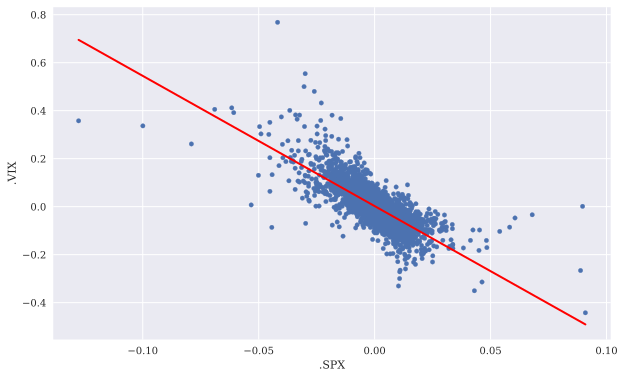

In [ ]:
ax = rets.plot(kind='scatter', x='.SPX', y='.VIX', figsize=(10, 6))  
ax.plot(rets['.SPX'], np.polyval(reg, rets['.SPX']), 'r', lw=2);  

### Correlation

In [ ]:
rets.corr()  

.SPX      .VIX
.SPX  1.000000 -0.760027
.VIX -0.760027  1.000000

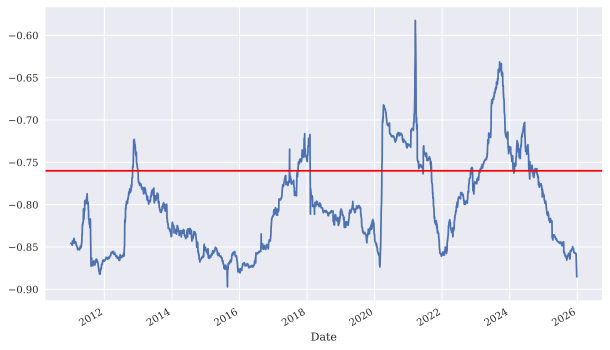

In [ ]:
ax = rets['.SPX'].rolling(window=252).corr(
                  rets['.VIX']).plot(figsize=(10, 6))  
ax.axhline(rets.corr().iloc[0, 1], c='r');  

## High Frequency yh_df

In [ ]:
# from dfcmpy import dfcmpy_tick_yh_df_reader as tdr
# yh_df = tdr('EURUSD', start='2018-6-25', end='2018-06-30')
# yh_df.get_yh_df(start='2018-6-29',
#               end='2018-06-30').to_csv('../../source/dfcm_eur_usd_tick_yh_df.csv')

In [ ]:
import os

# Tick yh_df CSV (original path from the book repo). If that path is not writable,
# fall back to ./source/ so "Run All" still works.
_default_tick_filename = '../../source/dfcm_eur_usd_tick_yh_df.csv'
_fallback_tick_filename = 'source/dfcm_eur_usd_tick_yh_df.csv'

try:
    os.makedirs(os.path.dirname(_default_tick_filename), exist_ok=True)
    tick_filename = _default_tick_filename
except Exception:
    os.makedirs(os.path.dirname(_fallback_tick_filename), exist_ok=True)
    tick_filename = _fallback_tick_filename

# If the dfCM tick CSV is not present, create a similar intraday file from Yahoo Finance.
# The rest of the section expects two columns (Bid, Ask) so that tick.mean(axis=1) gives a Mid price.
if not os.path.exists(tick_filename):
    try:
        try:
            import yfinance as yf
        except ImportError as e:
            raise RuntimeError(
                "yfinance is required to download intraday EURUSD yh_df. "
                "Install it with: pip install yfinance"
            ) from e

        # yfinance intraday yh_df has limited historical depth; use a recent window.
        tmp = yf.download('EURUSD=X', period='7d', interval='1m', progress=False)

        # Fallback in case 1m yh_df is not available (limits can vary)
        if tmp.empty:
            tmp = yf.download('EURUSD=X', period='60d', interval='5m', progress=False)

        mid = tmp['Close'].dropna()
        # If download returned no usable yh_df, trigger synthetic fallback.
        if mid.empty:
            raise RuntimeError('Downloaded intraday yh_df is empty.')

        spread = 0.00005  # ~0.5 pip spread (illustrative)

        tick_tmp = pd.DataFrame({
            'Bid': mid - spread / 2,
            'Ask': mid + spread / 2
        })

        tick_tmp.to_csv(tick_filename)
        print(f'Created {tick_filename} from Yahoo Finance with {tick_tmp.shape[0]} ticks.')
    except Exception as e:
        print('WARNING: Could not download intraday EURUSD yh_df from Yahoo Finance.')
        print('Falling back to synthetic tick yh_df so the notebook can run end-to-end.')
        print('Error was:', repr(e))

        rng = np.random.default_rng(7)
        idx = pd.date_range('2025-12-15', periods=3000, freq='S')
        mid = 1.10 + np.cumsum(rng.normal(loc=0.0, scale=1e-5, size=len(idx)))
        spread = 0.00005

        tick_tmp = pd.DataFrame({'Bid': mid - spread / 2, 'Ask': mid + spread / 2}, index=idx)
        tick_tmp.to_csv(tick_filename)
        print(f'Created synthetic {tick_filename} with {tick_tmp.shape[0]} ticks.')

In [ ]:
%%time
# yh_df from dfCM Forex Capital Markets Ltd.
tick = pd.read_csv(tick_filename,
                     index_col=0, parse_dates=True)

CPU times: user 2.12 ms, sys: 1.09 ms, total: 3.21 ms
Wall time: 2.72 ms


In [ ]:
tick.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3000 entries, 2025-12-15 00:00:00 to 2025-12-15 00:49:59
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Bid     3000 non-null   float64
 1   Ask     3000 non-null   float64
dtypes: float64(2)
memory usage: 70.3 KB


In [ ]:
tick['Mid'] = tick.mean(axis=1)  

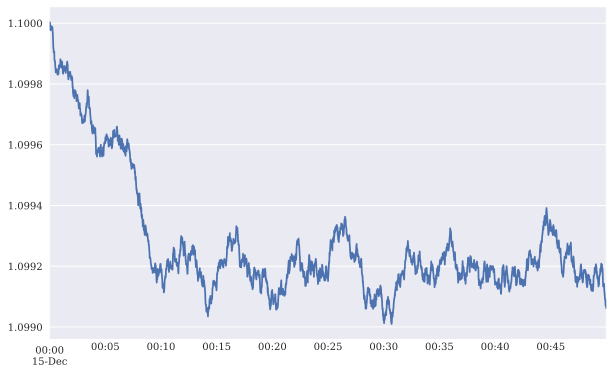

In [ ]:
tick['Mid'].plot(figsize=(10, 6));

In [ ]:
tick_resam = tick.resample(rule='5min', label='right').last()

In [ ]:
tick_resam.head()

Bid       Ask       Mid
2025-12-15 00:05:00  1.099579  1.099629  1.099604
2025-12-15 00:10:00  1.099173  1.099223  1.099198
2025-12-15 00:15:00  1.099096  1.099146  1.099121
2025-12-15 00:20:00  1.099097  1.099147  1.099122
2025-12-15 00:25:00  1.099138  1.099188  1.099163

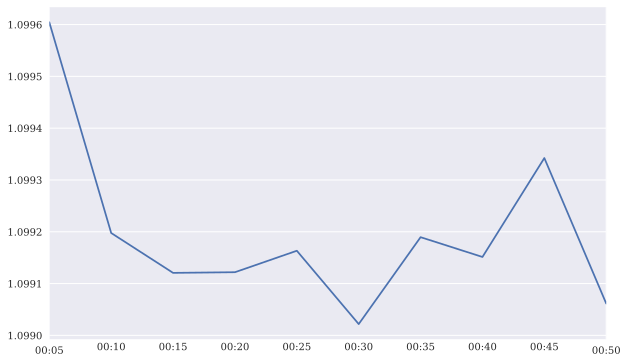

In [ ]:
tick_resam['Mid'].plot(figsize=(10, 6));